<a href="https://colab.research.google.com/github/hhoppe/advent_of_code_2019/blob/main/advent_of_code_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="top"></a>
# Advent of code 2019

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code_2019/blob/main/advent_of_code_2019.ipynb)

IPython/Jupyter [notebook](https://github.com/hhoppe/advent_of_code_2019/blob/main/advent_of_code_2019.ipynb) by [Hugues Hoppe](http://hhoppe.com/) with solutions to the [2019 Advent of Code puzzles](https://adventofcode.com/2019).
Mostly completed in March 2021.

In this notebook, I explore both "compact" and "fast" code versions, along with data visualizations.

I was able to speed up all the solutions such that the [cumulative time](#timings) across all 25 puzzles is about 5 s.
(For some puzzles, I had to resort to the `numba` package to jit-compile Python functions.)

Here are some visualization results:

<a href="#day10">day10</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day10.gif" height="150">
<a href="#day11">day11</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day11a.gif" height="200">
<img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day11b.gif" height="40">
<br/>
<a href="#day13">day13</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day13.gif" height="150">
<a href="#day15">day15</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day15a.gif" height="200">
<img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day15b.gif" height="200">
<br/>
<a href="#day17">day17</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day17.png" height="180">
<a href="#day18">day18</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day18a.gif" height="240">
<img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day18b.gif" height="240">
<a href="#day19">day19</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day19b.png" height="200">
<br/>
<a href="#day20">day20</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day20a.gif" height="250">
<img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day20b.gif" height="250">
<a href="#day24">day24</a><img src="https://github.com/hhoppe/advent_of_code_2019/raw/main/results/day24.gif" height="250">


<a name="preamble"></a>
## Preamble

In [1]:
!pip install -q advent-of-code-ocr advent-of-code-hhoppe hhoppe-utils mediapy

In [2]:
import collections
import dataclasses
import functools
import heapq
import itertools
import math
import random
import re
import sys
import textwrap
from typing import Any, Callable, Dict, List, Mapping
from typing import Optional, Set, Tuple, Union

import advent_of_code_hhoppe
import advent_of_code_ocr
import hhoppe_utils as hh
import mediapy as media
import numpy as np

In [3]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [4]:
hh.start_timing_notebook_cells()

In [5]:
YEAR = 2019

In [6]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
if 0:
  INPUT_URL = f'https://github.com/hhoppe/advent_of_code_{{year}}/raw/main/data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
  ANSWER_URL = f'https://github.com/hhoppe/advent_of_code_{{year}}/raw/main/data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'
else:  # Reduce network load.
  !if [[ ! -d {PROFILE} ]]; then wget -q https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.zip && unzip -q {PROFILE}; fi
  INPUT_URL = f'{PROFILE}/{{year}}_{{day:02d}}_input.txt'
  ANSWER_URL = f'{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [7]:
# (2) If URL not found, we may try adventofcode.com using a session cookie:
if 0:
  # See https://github.com/wimglenn/advent-of-code-data.
  !rm -f ~/.config/aocd/token*
  # Fill-in the session cookie in the following:
  !if [ '{PROFILE}' == 'google.Hugues_Hoppe.965276' ]; then mkdir -p ~/.config/aocd && echo 53616... >~/.config/aocd/token; fi
  !if [ '{PROFILE}' == 'github.hhoppe.1452460' ]; then mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token; fi
  !pip install -q advent-of-code-data
  import aocd

In [8]:
try:
  import numba
  numba_njit = numba.njit
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba_njit = hh.noop_decorator

In [9]:
advent = advent_of_code_hhoppe.Advent(
    year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

### Helper functions

In [10]:
check_eq = hh.check_eq

### `Machine` used in several puzzles

In [11]:
# Also called `IntCode` Machine in the puzzles.

class Machine_py:

  def __init__(self, s, *, mem_extend=0):
    assert not mem_extend
    self.mem = list(map(int, s.split(',')))
    self.terminated = False
    self._input = []
    self._output = []
    self._pc = 0
    self._relative_base = 0

  def execute_one_instruction(self):
    assert not self.terminated
    code = self.mem[self._pc]
    opcode = code % 100

    def possibly_grow_memory_to_access(i):
      assert 0 <= i < 1_000_000, i
      if i >= len(self.mem):
        self.mem += [0] * i  # grow quickly

    def read(i):
      possibly_grow_memory_to_access(i)
      return self.mem[i]

    def write(i, value):
      possibly_grow_memory_to_access(i)
      self.mem[i] = value

    def address(i):
      mode = (code // (10**(i + 1))) % 10
      if mode == 0:  # position mode
        return self.mem[self._pc + i]
      if mode == 2:  # relative mode
        return self._relative_base + self.mem[self._pc + i]
      raise RuntimeError(f'Unrecognized lhs mode {mode})')

    def operand(i):
      mode = (code // (10**(i + 1))) % 10
      if mode in (0, 2):
        return read(address(i))
      if mode == 1:  # immediate mode
        return self.mem[self._pc + i]
      raise RuntimeError(f'Unrecognized rhs mode {mode})')

    if opcode == 99:  # End
      assert not self._input
      self.terminated = True
    elif opcode == 1:  # Add
      write(address(3), operand(1) + operand(2))
      self._pc += 4
    elif opcode == 2:  # Multiply
      write(address(3), operand(1) * operand(2))
      self._pc += 4
    elif opcode == 3:  # Input
      write(address(1), self._input.pop(0))
      self._pc += 2
    elif opcode == 4:  # Output
      self._output.append(operand(1))
      self._pc += 2
    elif opcode == 5:  # Jump if true
      self._pc = operand(2) if operand(1) != 0 else self._pc + 3
    elif opcode == 6:  # Jump if false
      self._pc = operand(2) if operand(1) == 0 else self._pc + 3
    elif opcode == 7:  # Less
      write(address(3), int(operand(1) < operand(2)))
      self._pc += 4
    elif opcode == 8:  # Equal
      write(address(3), int(operand(1) == operand(2)))
      self._pc += 4
    elif opcode == 9:  # Adjust relative base
      self._relative_base += operand(1)
      self._pc += 2
    else:
      raise RuntimeError(f'Unrecognized opcode {opcode} (pc={self._pc})')

  def run_until_need_input(self, input=None):
    def next_opcode_is_input(): return self.mem[self._pc] == 3
    assert not self.terminated
    assert not self._output
    self._input = input if input is not None else []
    while not self.terminated:
      if next_opcode_is_input() and not self._input:
        break
      self.execute_one_instruction()
    assert not self._input
    output = self._output
    self._output = []
    return output

  def run_fully(self, input=None):
    output = self.run_until_need_input(input)
    assert self.terminated
    return output


def test_machine():
  def mem_after_machine_run(s):
    machine = Machine_py(s)
    machine.run_fully()
    return ','.join(map(str, machine.mem))

  s1 = '1,9,10,3,2,3,11,0,99,30,40,50'
  check_eq(mem_after_machine_run(s1), '3500,9,10,70,2,3,11,0,99,30,40,50')

  check_eq(mem_after_machine_run('1,0,0,0,99'), '2,0,0,0,99')  # 1 + 1 = 2
  check_eq(mem_after_machine_run('2,3,0,3,99'), '2,3,0,6,99')  # 3 * 2 = 6
  check_eq(mem_after_machine_run('2,4,4,5,99,0'), '2,4,4,5,99,9801')  # 99 * 99
  check_eq(mem_after_machine_run('1,1,1,4,99,5,6,0,99'), '30,1,1,4,2,5,6,0,99')

test_machine()

In [12]:
class Machine_numba:

  def __init__(self, s, *, mem_extend=10_000):
    # Preallocate extra memory because we do not grow it as in Machine_py.
    self.mem = np.concatenate((np.array(list(map(int, s.split(',')))),
                               np.zeros(mem_extend, dtype=np.int64)))
    self._pc = 0
    self._relative_base = 0
    self.terminated = False

  @staticmethod
  @numba_njit(cache=True)
  def _run(mem, pc, relative_base, input):
    input_index = 0
    output = []
    terminated = False

    while not terminated:
      code = mem[pc]
      opcode = code % 100
      if opcode == 3 and input_index == input.size:  # must wait for input
        break

      def read(i):
        return mem[i]

      def write(i, value):
        mem[i] = value

      def address(i):
        mode = (code // (10**(i + 1))) % 10
        if mode == 0:  # position mode
          return mem[pc + i]
        assert mode == 2  # relative mode
        return relative_base + mem[pc + i]

      def operand(i):
        mode = (code // (10**(i + 1))) % 10
        if mode in (0, 2):
          return read(address(i))
        assert mode == 1  # immediate mode
        return mem[pc + i]

      if opcode == 99:  # End
        assert input_index == input.size
        terminated = True
      elif opcode == 1:  # Add
        write(address(3), operand(1) + operand(2))
        pc += 4
      elif opcode == 2:  # Multiply
        write(address(3), operand(1) * operand(2))
        pc += 4
      elif opcode == 3:  # Input
        write(address(1), input[input_index])
        input_index += 1
        pc += 2
      elif opcode == 4:  # Output
        output.append(operand(1))
        pc += 2
      elif opcode == 5:  # Jump if true
        pc = operand(2) if operand(1) != 0 else pc + 3
      elif opcode == 6:  # Jump if false
        pc = operand(2) if operand(1) == 0 else pc + 3
      elif opcode == 7:  # Less
        write(address(3), int(operand(1) < operand(2)))
        pc += 4
      elif opcode == 8:  # Equal
        write(address(3), int(operand(1) == operand(2)))
        pc += 4
      elif opcode == 9:  # Adjust relative base
        relative_base += operand(1)
        pc += 2
      else:
        assert False

    return pc, relative_base, terminated, output

  def run_until_need_input(self, input=()):
    assert not self.terminated
    self._pc, self._relative_base, self.terminated, output = self._run(
        self.mem, self._pc, self._relative_base,
        np.array(input, dtype=np.int64))
    return output

  def run_fully(self, input=()):
    output = self.run_until_need_input(input)
    assert self.terminated
    return output

In [13]:
def test_machine(MachineType):
  def mem_after_machine_run(s):
    machine = MachineType(s, mem_extend=0)
    machine.run_fully()
    return ','.join(map(str, machine.mem))

  s1 = '1,9,10,3,2,3,11,0,99,30,40,50'
  check_eq(mem_after_machine_run(s1), '3500,9,10,70,2,3,11,0,99,30,40,50')

  check_eq(mem_after_machine_run('1,0,0,0,99'), '2,0,0,0,99')  # 1 + 1 = 2
  check_eq(mem_after_machine_run('2,3,0,3,99'), '2,3,0,6,99')  # 3 * 2 = 6
  check_eq(mem_after_machine_run('2,4,4,5,99,0'), '2,4,4,5,99,9801')  # 99 * 99
  check_eq(mem_after_machine_run('1,1,1,4,99,5,6,0,99'), '30,1,1,4,2,5,6,0,99')


for MachineType in (Machine_py, Machine_numba):
  test_machine(MachineType)  # ~4 s for numba compilation.

Machine = Machine_numba if 'numba' in globals() else Machine_py

In [14]:
if 0:  # For quick timing test while developing.
  puzzle = advent.puzzle(day=13, silent=True)

  def run_game(s, verbose=False):
    machine = Machine(s)
    machine.mem[0] = 2  # set free play
    score = None
    last_yx = {}
    input = []

    while not machine.terminated:
      output = machine.run_until_need_input(input)
      for x, y, tile_id in hh.grouped(output, 3):
        if (x, y) == (-1, 0):
          score = tile_id
        elif tile_id in (4, 3):  # ball or paddle
          last_yx[tile_id] = (y, x)
      joystick = np.sign(last_yx[4][1] - last_yx[3][1])  # ball.x - paddle.x
      input = [joystick]
    return score


  puzzle.verify(2, run_game)  # ~60 ms with Machine_numba; ~3 s without.

## Day 1: Fuel mass

Given space modules with mass, report sum of fuel requirements.

- Part 1: To find the fuel required for a module, take its mass, divide by three, round down, and subtract 2.

- Part 2: The fuel itself has mass and requires additional fuel, recursively.

In [15]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2019/day/1), `puzzle.input` has 100 lines:

115810
58892
76569
87782
103850
103320
62798
98400
 ...
138309
107308
146818
63364


The stored answers are: `{1: '3235550', 2: '4850462'}`

In [16]:
def process1(s, part2=False):

  def get_fuel(mass):
    return max(mass // 3 - 2, 0)

  check_eq(get_fuel(0), 0)
  check_eq(get_fuel(12), 2)
  check_eq(get_fuel(14), 2)
  check_eq(get_fuel(1969), 654)
  check_eq(get_fuel(100756), 33583)

  def get_adjusted_fuel(mass):
    fuel = get_fuel(mass)
    if fuel:
      fuel += get_adjusted_fuel(fuel)
    return fuel

  check_eq(get_adjusted_fuel(14), 2)
  check_eq(get_adjusted_fuel(1969), 966)
  check_eq(get_adjusted_fuel(100756), 50346)

  func = get_adjusted_fuel if part2 else get_fuel
  return sum(func(int(mass)) for mass in s.split())


puzzle.verify(1, process1)  # ~1 ms.
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.001 s)


## Day 2: Machine with add/subtract

Create Intcode computer with opcodes for addition, subtraction, and termination.

- Part 1: Before running the program, replace position 1 with the value 12 and replace position 2 with the value 2.  Report value is at position 0 after the program halts.

- Part 2: Determine what pair of inputs (at addresses 1 and 2) produces the output 19690720 (at address 0).

In [17]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2019/day/2), `puzzle.input` has a single line of 420 characters:

1,0,0,3,1,1,2,3,1,3,4,3,1,5,0,3,2,13,1,19,1,10,19,23,1,23,9,27,1,5,27,31,2,31,13 ... ,1,2,143,147,1,147,10,0,99,2,0,14,0


The stored answers are: `{1: '4930687', 2: '5335'}`

In [18]:
def process1(s, part2=False):  # Original implementation before Machine.

  def day2_machine_op(s, a=12, b=2):
    l = list(map(int, s.split(',')))
    l[1] = a
    l[2] = b
    i = 0
    while True:
      if l[i] == 99:
        break
      elif l[i] == 1:
        l[l[i + 3]] = l[l[i + 1]] + l[l[i + 2]]
        i += 4
      elif l[i] == 2:
        l[l[i + 3]] = l[l[i + 1]] * l[l[i + 2]]
        i += 4
      else:
        raise RuntimeError(f'? {l}')
    return l[0]

  if not part2:
    return day2_machine_op(s)

  for a_plus_b in range(200):
    for a in range(min(a_plus_b, 100)):
      b = a_plus_b - a
      if day2_machine_op(s, a, b) == 19690720:
        hh.show(a, b)
        return a * 100 + b


puzzle.verify(1, process1)  # ~0 ms.
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~175 ms.

(Part 1: 0.000 s)


a = 53, b = 35


(Part 2: 0.213 s)


In [19]:
def process1(s, part2=False):  # Now using Machine class.

  def day2_machine_op(s, a=12, b=2):
    machine = Machine(s)
    machine.mem[1] = a
    machine.mem[2] = b
    machine.run_fully()
    return machine.mem[0]

  if not part2:
    return day2_machine_op(s)

  for a_plus_b in range(200):
    for a in range(min(a_plus_b, 100)):
      b = a_plus_b - a
      if day2_machine_op(s, a, b) == 19690720:
        hh.show(a, b)
        return a * 100 + b


puzzle.verify(1, process1)  # ~0 ms.
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~220 ms with Machine_numba; ~900 ms without.

(Part 1: 0.000 s)


a = 53, b = 35


(Part 2: 0.259 s)


## Day 3: Intersections of two paths

Given two paths, each described as a sequence of comma-separated axis-movements `[UDLR]value`:

- Part 1: Find the Manhattan distance from the origin to the closest intersection of the two paths.

- Part 2: Compute the number of steps along the path to each intersection.  Report the fewest combined steps the two paths must take to reach an intersection.

In [20]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2019/day/3), `puzzle.input` has 2 lines:

R1003,D138,L341,U798,L922,U153,R721,D177,L297,D559,L414,U470,L589,D179,L267,D954 ... 9,L641,U73,L294,D247,R944,U512,L396
L1004,D252,L909,D935,R918,D981,L251,U486,R266,U613,L546,D815,L789,D692,L550,U633 ... U447,R966,U346,L636,D9,L480,D35,R96


The stored answers are: `{1: '446', 2: '9006'}`

In [21]:
s1 = """
R8,U5,L5,D3
U7,R6,D4,L4
"""

s2 = """
R75,D30,R83,U83,L12,D49,R71,U7,L72
U62,R66,U55,R34,D71,R55,D58,R83
"""

s3 = """
R98,U47,R26,D63,R33,U87,L62,D20,R33,U53,R51
U98,R91,D20,R16,D67,R40,U7,R15,U6,R7
"""

In [22]:
def process1(s):  # Abandonned slow version, using large 2D images.
  shape = np.array((20,) * 2)  # Y, X
  origin = shape // 2

  def vec_from_move(move: str) -> np.ndarray:
    dir, mag = move[:1], int(move[1:])
    if dir == 'L':
      return np.array((0, -mag))
    if dir == 'R':
      return np.array((0, +mag))
    if dir == 'U':
      return np.array((-mag, 0))
    if dir == 'D':
      return np.array((+mag, 0))
    raise RuntimeError(f'Unrecognized move {move}')

  def rasterize(path: str):
    moves = path.split(',')
    position = origin.copy()
    grid = np.full(shape, 0, dtype=np.uint8)
    count = 0
    for move in moves:
      vec = vec_from_move(move)
      # print(f'position={position} vec={vec}')
      while vec.any():
        step = np.sign(vec)
        vec -= step
        position = position + step
        count += 1
        if not grid[tuple(position)]:
          grid[tuple(position)] = count
    return grid

  path1, path2 = s.strip('\n').split('\n')
  grid1 = rasterize(path1)
  grid2 = rasterize(path2)
  intersect = (grid1 > 0) & (grid2 > 0)
  media.show_images([grid1, grid2, intersect], height=shape[0] * 4)
  intersections = (np.moveaxis(np.indices(shape), 0, -1) -
                   origin)[intersect > 0]
  # print(intersections)
  return abs(intersections).sum(axis=-1).min()


check_eq(process1(s1), 6)  # [[-5  6] [-3  3]]

,,


In [23]:
def process1(s, part2=False):  # Using a sparse map on 2D positions.

  def rasterize(path: str):
    dyx_from_move = dict(L=(0, -1), R=(0, +1), U=(-1, 0), D=(+1, 0))
    yx = (0, 0)
    counts = {}
    count = 0
    for move in path.split(','):
      dyx, magnitude = dyx_from_move[move[:1]], int(move[1:])
      for _ in range(magnitude):
        count += 1
        yx = yx[0] + dyx[0], yx[1] + dyx[1]
        if yx not in counts:
          counts[yx] = count
    if 0:
      print(f'y:{hh.Stats(yx[0] for yx in counts)}')
      print(f'x:{hh.Stats(yx[1] for yx in counts)}')
      # y:(   148791)        -7052 : 1558         av=-1919.52     sd=2129.35
      # x:(   148791)        -5635 : 1003         av=-2209.31     sd=1405.76
      # y:(   157561)       -17468 : 2576         av=-6868.07     sd=6164.86
      # x:(   157561)        -2865 : 9691         av=5058.61      sd=3179.34
      # The paths are a bit too large to store in a grid or visualize.
    return counts

  path1, path2 = s.strip('\n').split('\n')
  counts1 = rasterize(path1)
  counts2 = rasterize(path2)

  if not part2:
    return min(abs(y) + abs(x) for y, x in counts1 if (y, x) in counts2)
  else:
    return min((counts1[pos] + counts2[pos])
               for pos in counts1 if pos in counts2)


check_eq(process1(s1), 6)  # [(-5, 6), (-3, 3)]
check_eq(process1(s2), 159)
check_eq(process1(s3), 135)
puzzle.verify(1, process1)  # ~230 ms.

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 30)
check_eq(process2(s2), 610)
check_eq(process2(s3), 410)
puzzle.verify(2, process2)  # ~230 ms.

(Part 1: 0.329 s)
(Part 2: 0.298 s)


In [24]:
def process1(s, part2=False):  # Using numba to operate on dict is slow.

  @numba_njit(cache=True)
  def rasterize(path):
    y, x = 0, 0
    counts = {}
    count = 0
    for dy, dx, magnitude in path:
      for _ in range(magnitude):
        count += 1
        y, x = y + dy, x + dx
        if (y, x) not in counts:
          counts[y, x] = count
    return counts

  path1, path2 = s.strip('\n').split('\n')
  dyx_from_move = dict(L=(0, -1), R=(0, +1), U=(-1, 0), D=(+1, 0))
  counts1, counts2 = [
      rasterize(np.array([[*dyx_from_move[move[:1]], int(move[1:])]
                          for move in path.split(',')]))
      for path in [path1, path2]
  ]

  if not part2:
    return min(abs(y) + abs(x) for y, x in counts1 if (y, x) in counts2)
  else:
    return min((counts1[pos] + counts2[pos])
               for pos in counts1 if pos in counts2)


check_eq(process1(s1), 6)  # [(-5, 6), (-3, 3)]
check_eq(process1(s2), 159)
check_eq(process1(s3), 135)
# puzzle.verify(1, process1)  # ~730 ms.

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 30)
check_eq(process2(s2), 610)
check_eq(process2(s3), 410)
# puzzle.verify(2, process2)  # ~730 ms.

## Day 4: Valid 6-digit passwords

Count the number of 6-digit passwords within the range specified in the input that satisfy:

- Part 1: (a) Two adjacent digits are the same, and (b) the digits never decrease.

- Part 2: and (c) the two adjacent matching digits are not part of a larger group of matching digits.

In [25]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2019/day/4), `puzzle.input` has a single line of 13 characters:

152085-670283


The stored answers are: `{1: '1764', 2: '1196'}`

In [26]:
def process1(s):  # Slow brute-force.
  lb, ub = map(int, s.split('-'))

  def two_adjacent_are_same(s):
    return any(a == b for a, b in zip(s, s[1:]))

  def digits_never_decrease(s):
    return all(a <= b for a, b in zip(s, s[1:]))

  count = 0
  for i in range(lb, ub + 1):
    s = str(i)
    count += two_adjacent_are_same(s) and digits_never_decrease(s)
  return count


puzzle.verify(1, process1)  # ~1000 ms.

(Part 1: 1.020 s)


In [27]:
def process1(s, part2=False):  # Recursive search with pruning.
  lower, upper = (tuple(map(int, list(b))) for b in s.strip().split('-'))

  def two_adjacent_are_same(t):
    return any(a == b for a, b in zip(t, t[1:]))

  def have_exactly_two_adjacent(t):
    e = (-1, *t, -1)
    return any(a != b and b == c and c != d
              for a, b, c, d in zip(e, e[1:], e[2:], e[3:]))

  def recurse(base):
    count = 0
    for digit in range((base[-1] if base else 0), 10):
      t = base + (digit,)
      if (*t, 10) < lower or t > upper:
        continue
      if len(t) == 6:
        count += (have_exactly_two_adjacent(t) if part2
                  else two_adjacent_are_same(t))
      else:
        count += recurse(t)
    return count

  return recurse(())


puzzle.verify(1, process1)  # ~4 ms.
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~5 ms.

(Part 1: 0.004 s)
(Part 2: 0.006 s)


## Day 5: Machine with branching

Extend the Intcode machine to support (1) input/output opcodes and both position and immediate operand modes, then (2) branch and comparison opcodes.

- Part 1: After providing input [1], report the output diagnostic code which comes after a sequence of zeros.

- Part 2: After providing input [5], report the output diagnostic code.

In [28]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2019/day/5), `puzzle.input` has a single line of 2_558 characters:

3,225,1,225,6,6,1100,1,238,225,104,0,1102,91,92,225,1102,85,13,225,1,47,17,224,1 ... ,224,674,101,1,223,223,4,223,99,226


The stored answers are: `{1: '16489636', 2: '9386583'}`

In [29]:
def test():
  for input in (7, 8, 9):
    check_eq(Machine('3,9,8,9,10,9,4,9,99,-1,8').run_fully([input]),
             [input == 8])
  for input in (7, 8, 9):
    check_eq(Machine('3,9,7,9,10,9,4,9,99,-1,8').run_fully([input]),
             [input < 8])
  for input in (7, 8, 9):
    check_eq(Machine('3,3,1108,-1,8,3,4,3,99').run_fully([input]),
             [input == 8])
  for input in (7, 8, 9):
    check_eq(Machine('3,3,1107,-1,8,3,4,3,99').run_fully([input]),
             [input < 8])

  for input in (-1, 0, 1):
    s = '3,12,6,12,15,1,13,14,13,4,13,99,-1,0,1,9'
    check_eq(Machine(s).run_fully([input]), [int(input != 0)])
  for input in (-1, 0, 1):
    s = '3,3,1105,-1,9,1101,0,0,12,4,12,99,1'
    check_eq(Machine(s).run_fully([input]), [int(input != 0)])

  s = '3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99'
  for input in (7, 8, 9):
    expected = 999 if input < 8 else 1000 if input == 8 else 1001
    check_eq(Machine(s).run_fully([input]), [expected])

test()

In [30]:
def process1(s, part2=False):
  output = Machine(s).run_fully([5 if part2 else 1])
  if part2:
    assert len(output) == 1
    return output[0]
  assert len(output) > 1 and not any(output[:-1])
  return output[-1]


puzzle.verify(1, process1)  # ~0 ms.
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~0 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


## Day 6: Count orbit transfers

Given a sequence of orbit relationships, where`'A)B'` indicates `B` orbits `A`:

- Part 1: Report the total number of direct and indirect orbits.

- Part 2: Report the number of orbital transfers you (`YOU`) need to take to get to Santa (`SAN`).

In [31]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2019/day/6), `puzzle.input` has 1_069 lines:

FGY)61Z
2BN)LM7
QXY)TVB
5M5)Y6C
2L2)64M
6TT)183
H6P)6TT
LPL)WP5
 ...
SKV)YWS
72M)F1F
3ZK)RSW
1LV)GFH


The stored answers are: `{1: '162816', 2: '304'}`

In [32]:
def process1(s, part2=False, source='YOU', destination='SAN'):

  def get_orbit_parents(s):
    parents = {}
    for entry in s.split():
      parent, child = entry.split(')')
      parents[child] = parent
    return parents

  def all_orbits(node):
    return 1 + all_orbits(parents[node]) if node in parents else 0

  parents = get_orbit_parents(s)

  if not part2:
    return sum(all_orbits(node) for node in parents)

  distances = {}
  node = source
  distance = -1
  while node in parents:
    node = parents[node]
    distance += 1
    distances[node] = distance

  node = destination
  distance = -1
  while node not in distances:
    node = parents[node]
    distance += 1

  return distances[node] + distance


s1 = 'COM)B B)C C)D D)E E)F B)G G)H D)I E)J J)K K)L'
check_eq(process1(s1), 42)
puzzle.verify(1, process1)  # ~35 ms.

process2 = functools.partial(process1, part2=True)
s2 = 'COM)B B)C C)D D)E E)F B)G G)H D)I E)J J)K K)L K)YOU I)SAN'
check_eq(process2(s2), 4)  # (3 + 1)
puzzle.verify(2, process2)  # ~1 ms.

(Part 1: 0.037 s)
(Part 2: 0.001 s)


## Day 7: Cycle of 5 machines

Given a set of 5 amplifiers (Intcode computers) connected together (output-to-input), determine their settings (unique phase numbers `0-4`) to maximize the final output value (thrust).

- Part 1: The 5 amplifiers are connected sequentially; report the max thrust.

- Part 2: The 5 amplifiers are connected in a loop; report the max thrust.

In [33]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2019/day/7), `puzzle.input` has a single line of 1_222 characters:

3,8,1001,8,10,8,105,1,0,0,21,38,59,76,89,106,187,268,349,430,99999,3,9,1002,9,3, ... 1001,9,2,9,4,9,3,9,102,2,9,9,4,9,99


The stored answers are: `{1: '199988', 2: '17519904'}`

In [34]:
def process1(s, return_all=False):

  def get_thrust(s, phases):
    check_eq(sorted(phases), list(range(5)))
    value = 0
    for i in range(5):
      value, = Machine(s).run_fully([phases[i], value])
    return value

  all_phases = itertools.permutations(range(5))
  thrusts = {phases: get_thrust(s, phases) for phases in all_phases}
  best_phases, best_thrust = max(thrusts.items(), key=lambda pair: pair[::-1])
  return (best_thrust, best_phases) if return_all else best_thrust


s1 = '3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0'
check_eq(process1(s1, return_all=True), (43210, (4, 3, 2, 1, 0)))

s2 = '3,23,3,24,1002,24,10,24,1002,23,-1,23,101,5,23,23,1,24,23,23,4,23,99,0,0'
check_eq(process1(s2, return_all=True), (54321, (0, 1, 2, 3, 4)))

s3 = '3,31,3,32,1002,32,10,32,1001,31,-2,31,1007,31,0,33,1002,33,7,33,1,33,31,31,1,32,31,31,4,31,99,0,0,0'
check_eq(process1(s3, return_all=True), (65210, (1, 0, 4, 3, 2)))

puzzle.verify(1, process1)  # ~80 ms.

(Part 1: 0.080 s)


In [35]:
def process2(s, return_all=False):

  def get_thrust2(phases):
    check_eq(sorted(phases), list(range(5, 10)))
    machines = [Machine(s) for _ in range(5)]
    value = 0
    for step in itertools.count():
      for i in range(5):
        machine = machines[i]
        input = ([phases[i]] if step == 0 else []) + [value]
        value, = machine.run_until_need_input(input)
      terminated = [machines[i].terminated for i in range(5)]
      if any(terminated):
        assert all(terminated)
        return value

  all_phases = itertools.permutations(range(5, 10))
  best_phases = max(all_phases, key=get_thrust2)
  best_thrust = get_thrust2(best_phases)
  return (best_thrust, best_phases) if return_all else best_thrust


# Max thruster signal 139629729 (from phase setting sequence 9,8,7,6,5):
s1 = '3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5'
check_eq(process2(s1, return_all=True), (139629729, (9, 8, 7, 6, 5)))

# Max thruster signal 18216 (from phase setting sequence 9,7,8,5,6):
s2 = '3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10'
check_eq(process2(s2, return_all=True), (18216, (9, 7, 8, 5, 6)))

puzzle.verify(2, process2)  # ~105 ms.

(Part 2: 0.120 s)


## Day 8: Compositing image layers

Given pixel values for a multilayer input image (width=25, height=6), as sequence of digits `0-2` in raster order over consecutive layers:

- Part 1: For the layer with the fewest `0` digits, report the number of `1` digits multiplied by the number of `2` digits.

- Part 2: Composite the layers together (first layer is frontmost), interpreting digit `2` as transparent.  Report the message in the resulting image.

In [36]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2019/day/8), `puzzle.input` has a single line of 15_000 characters:

22122222202222222222222202022222222202222001210200222022222222222222222222012220 ... 10110222221001011100100210100021201


The stored answers are: `{1: '2975', 2: 'EHRUE'}`

In [37]:
def process1(s, part2=False):
  s = s.strip('\n')
  grid = hh.grid_from_string(s).astype(np.uint8).reshape(-1, 6, 25)

  if not part2:
    layer_num_zero_digits = np.count_nonzero(grid == 0, axis=(1, 2))
    index_layer_fewest_zero_digits = layer_num_zero_digits.argmin()
    layer = grid[index_layer_fewest_zero_digits]
    counts = np.bincount(layer.reshape(-1))
    return counts[1] * counts[2]

  def composite(layers):
    # 0 is black, 1 is white, and 2 is transparent

    def binary_op(layer1, layer2):
      return np.where(layer1 < 2, layer1, layer2)

    return functools.reduce(binary_op, layers)

  # s1 = array_from_string('0222112222120000').reshape(-1, 2, 2)
  # check_eq(composite(s1), array_from_string('0110').reshape(2, 2))

  result = np.pad(composite(grid), 0)
  print(result)
  assert np.all(result < 2)
  result2 = np.pad(result, 1)
  media.show_image(result2, height=result2.shape[0] * 2)

  s = hh.string_from_grid(result, {0: '.', 1: '#'})
  answer = advent_of_code_ocr.convert_6(s)  # e.g. 'EHRUE'
  print(answer)
  return answer


puzzle.verify(1, process1)  # ~5 ms.

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~14 ms.

(Part 1: 0.008 s)
[[1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0]
 [1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0]
 [1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0]
 [1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0]]


""


EHRUE
(Part 2: 0.020 s)


## Day 9: Machine with relative base

Extend the Intcode machine to support a relative base address.

- Part 1: Report the value output by the program given input `[1]`.

- Part 2: Report the value output by the program given input `[2]`.


In [38]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2019/day/9), `puzzle.input` has a single line of 3_397 characters:

1102,34463338,34463338,63,1007,63,34463338,63,1005,63,53,1102,1,3,1000,109,988,2 ... 1,968,22102,1,-2,-2,109,-3,2105,1,0


The stored answers are: `{1: '2457252183', 2: '70634'}`

In [39]:
def test():
  # produces a copy of itself as output
  s = '109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99'
  expected = list(map(int, s.split(',')))
  check_eq(Machine(s).run_fully(), expected)

  # should output a 16-digit number
  s = '1102,34915192,34915192,7,4,7,99,0'
  result = Machine(s).run_fully()[0]
  check_eq(len(str(result)), 16)

  # should output the large number in the middle
  s = '104,1125899906842624,99'
  check_eq(Machine(s).run_fully()[0], 1125899906842624)

test()

In [40]:
def process1(s, part2=False):
  input = 2 if part2 else 1
  output, = Machine(s).run_fully([input])
  return output

puzzle.verify(1, process1)  # ~1 ms.

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~11 ms with Machine_numba; ~1300 ms without.

(Part 1: 0.001 s)
(Part 2: 0.017 s)


## Day 10: Vaporize occluded asteroids

Given a 2D map representing asteroids as `'#'`:

- Part 1: Determine the asteroid that can see the most number of other asteroids (accounting for occlusions), and report the number of seen asteroids.

- Part 2: Simulate a laser that rotates clockwise on Part 1 asteroid and vaporizes unoccluded asteroids.  Determine the `x, y` location of the 200th vaporized asteroid and report `100 * x + y`.

In [41]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2019/day/10), `puzzle.input` has 26 lines:

##.#..#..###.####...######
#..#####...###.###..#.###.
..#.#####....####.#.#...##
.##..#.#....##..##.#.#....
#.####...#.###..#.##.#..#.
..#..#.#######.####...#.##
#...####.#...#.#####..#.#.
.#..#.##.#....########..##
 ...
#..#..########.#.#...#..##
.##..#.####....#..#..#....
.###.##..#####...###.#.#.#
.##..######...###..#####.#


The stored answers are: `{1: '284', 2: '404'}`

In [42]:
#@title
# Indent lines to avoid b/174323966 (Colab ... prefix in multiline string).
# An alternative is textwarp.dedent() or re.sub(r'(?m)^  ', r'', s.strip('\n')).
s1 = """
  .#..#
  .....
  #####
  ....#
  ...##
""".replace(' ', '')

s2 = """
  .#....#####...#..
  ##...##.#####..##
  ##...#...#.#####.
  ..#.....#...###..
  ..#.#.....#....##
""".replace(' ', '')

s3 = """
  .#..##.###...#######
  ##.############..##.
  .#.######.########.#
  .###.#######.####.#.
  #####.##.#.##.###.##
  ..#####..#.#########
  ####################
  #.####....###.#.#.##
  ##.#################
  #####.##.###..####..
  ..######..##.#######
  ####.##.####...##..#
  .#####..#.######.###
  ##...#.##########...
  #.##########.#######
  .####.#.###.###.#.##
  ....##.##.###..#####
  .#.#.###########.###
  #.#.#.#####.####.###
  ###.##.####.##.#..##
""".replace(' ', '')

print('Define strings s1, s2, and s3.')

Define strings s1, s2, and s3.


In [43]:
def process1(s, part2=False, return_final=True, index_vaporized=199,
            visualize=False):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1})
  indices = list(zip(*grid.nonzero()))

  @numba_njit(cache=True)
  def is_visible(dst_yx, src_yx, grid):
    yx = src_yx
    vec = dst_yx[0] - yx[0], dst_yx[1] - yx[1]
    gcd = math.gcd(*vec)  # (gcd(0, x) = x is good; gcd(0, 0) = 0)
    vec = vec[0] // gcd, vec[1] // gcd
    for _ in range(gcd - 1):  # ignore endpoints
      yx = yx[0] + vec[0], yx[1] + vec[1]
      if grid[yx]:
        return False
    return True

  def count_visible_from(yx):
    return sum(yx2 != yx and is_visible(yx2, yx, grid) for yx2 in indices)

  best_count, best_yx = max((count_visible_from(yx), yx) for yx in indices)
  if not part2:
    return best_count if return_final else (best_yx[::-1], best_count)

  src_yx = best_yx
  grid[src_yx] = 0  # ignore source base asteroid
  vaporized = []
  time_vaporized = np.full_like(grid, 0, dtype=np.int32)
  count_vaporized = 0
  images = []
  while True:
    sweep_vaporized = []  # asteroids vaporized in one 360-degree sweep
    y, x = grid.nonzero()
    if not len(y):
      break
    dy, dx = y - src_yx[0], x - src_yx[1]
    # Note that arctan2(y, x) returns (-np.pi, +np.pi], so angle is 0.0 along
    # +X axis and increases towards +Y axis.
    angle = np.arctan2(dx, -dy)  # clockwise with angle 0.0 at top
    angle = np.where(angle < 0.0, angle + math.tau, angle)  # [0.0, tau)
    t = np.full_like(grid, np.inf, dtype=np.float32)
    t[y, x] = angle
    for _, dst_y, dst_x in sorted(zip(angle, y, x)):
      if is_visible((dst_y, dst_x), src_yx, grid):
        count_vaporized += 1
        time_vaporized[dst_y, dst_x] = count_vaporized
        sweep_vaporized.append((dst_y, dst_x))
    for dst_y, dst_x in sweep_vaporized:
      if visualize:
        image = media.to_rgb(grid == 0)
        image[src_yx] = (255, 0, 0)
        image = image.repeat(4, axis=0).repeat(4, axis=1)
        images.append(image)
      grid[dst_y, dst_x] = 0
    vaporized.extend(sweep_vaporized)

  if visualize:
    images = [images[0]] * 25 + images + [images[-1]] * 25
    media.show_video(
        images, codec='gif', fps=25, border=True)
  if 0 and index_vaporized == 35:
    with np.printoptions(linewidth=1000):
      print(time_vaporized)
  return vaporized[index_vaporized][1] * 100 + vaporized[index_vaporized][0]


check_eq(process1(s1, return_final=False), ((3, 4), 8))

puzzle.verify(1, process1)  # ~150 ms with numba; ~250 ms without numba.

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2, index_vaporized=35), 1403)
check_eq(process2(s3), 802)
puzzle.verify(2, process2)  # ~150 ms with numba; ~250 ms without numba.

(Part 1: 0.146 s)
(Part 2: 0.152 s)


""

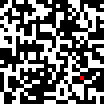

In [44]:
_ = process2(puzzle.input, visualize=True)

## Day 11: Turtle walk painting

The given Intcode program lets a painting robot traverses a 2D grid.
It successively reads the current color, emits a paint color (`0`: black, `1`: white) and rotation (`0`: left, `1`: right) and then move forward.

- Part 1: Report the number of panels painted at least once.

- Part 2: Change the color of the starting tile to white and run again.  Report the drawn text message.

In [45]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2019/day/11), `puzzle.input` has a single line of 2_051 characters:

3,8,1005,8,319,1106,0,11,0,0,0,104,1,104,0,3,8,1002,8,-1,10,101,1,10,10,4,10,108 ... 1,-2,22201,-4,-2,-4,109,-5,2105,1,0


The stored answers are: `{1: '1985', 2: 'BLCZCJLZ'}`

In [46]:
def process1(s, part2=False, visualize_nth=0):

  class Painter:

    def __init__(self, visualize_nth=0):
      self.painted = {}  # (y, x) -> value 0 or 1
      self.yx = (0, 0)  # position (initially at origin)
      self.dyx = (-1, 0)  # direction (initially up)
      self.visualize_nth = visualize_nth
      self.num_paints = 0
      self.num_frames = 0
      self.tyx_white = set()

    def paint_color(self, color):
      self.painted[self.yx] = color
      if self.visualize_nth and (self.num_paints < self.visualize_nth or
                                self.num_paints % self.visualize_nth == 0):
        self.tyx_white.update((self.num_frames, *yx)
                              for yx, value in self.painted.items() if value)
        self.num_frames += 1
      self.num_paints += 1

    def advance(self, turn):  # 0=left, 1=right
      self.dyx = ((self.dyx[1], -self.dyx[0]) if turn else
                  (-self.dyx[1], self.dyx[0]))
      self.yx = self.yx[0] + self.dyx[0], self.yx[1] + self.dyx[1]

    def current_color(self):
      return self.painted.get(self.yx, 0)

    def num_painted(self):
      return len(self.painted)

    def visualized_grid(self):
      indices = {yx for yx, value in self.painted.items() if value == 1}
      return hh.grid_from_indices(indices, dtype=np.uint8, pad=0)

    def finish(self):
      if self.visualize_nth:
        video = hh.grid_from_indices(self.tyx_white, pad=(0, 1, 1), dtype=bool)
        video = video.repeat(2, axis=1).repeat(2, axis=2)
        video = [video[0]] * 25 + list(video) + [video[-1]] * 25
        media.show_video(video, codec='gif', fps=25)


  def test():
    small = [
        (1, 0),  # paint white, turn left, advance W
        (0, 0),  # paint black, turn left, advance S
        (1, 0),  # paint white, turn left, advance E
        (1, 0),  # paint white, turn left, advance N
        (0, 1),  # paint black, turn right, advance E
        (1, 0),  # paint white, turn left, advance N
        (1, 0),  # paint white, turn left, advance W
    ]
    painter = Painter()  # visualize_nth=1
    for color, turn in small:
      painter.paint_color(color)
      painter.advance(turn)
    painter.finish()
    check_eq(painter.num_painted(), 6)

  test()

  machine = Machine(s)
  painter = Painter(visualize_nth=visualize_nth)
  initial_color = 1 if part2 else 0
  painter.paint_color(initial_color)
  check_eq(machine.run_until_need_input(), [])
  while not machine.terminated:
    color, turn = machine.run_until_need_input([painter.current_color()])
    painter.paint_color(color)
    painter.advance(turn)

  painter.finish()
  if not part2:
    return painter.num_painted()

  grid = painter.visualized_grid()
  s = hh.string_from_grid(grid, {0: '.', 1:'#'})
  answer = advent_of_code_ocr.convert_6(s)  # e.g. 'BLCZCJLZ'
  if not visualize_nth:
    print(answer)
  return answer


puzzle.verify(1, process1)  # ~50 ms with Machine_numba; ~400 ms without.

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~10 ms with Machine_numba; ~40 ms without.

(Part 1: 0.064 s)
BLCZCJLZ
(Part 2: 0.006 s)


""

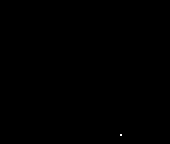

""


In [47]:
_ = process1(puzzle.input, visualize_nth=16)
_ = process2(puzzle.input, visualize_nth=1)

## Day 12: Periodic n-body problem

Given initial positions for a set of 4 moons in a 3D integer lattice, simulate their motions, where the inter-moon gravitational force for each coordinate equals the sign of the position difference.

- Part 1: Compute the sum of "potential" and "kinetic" energies after 1000 simulation steps.

- Part 2: Report the number of simulation steps before all positions and velocities repeat.

In [48]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2019/day/12), `puzzle.input` has 4 lines:

<x=-6, y=2, z=-9>
<x=12, y=-14, z=-4>
<x=9, y=5, z=-6>
<x=-1, y=-4, z=9>


The stored answers are: `{1: '14907', 2: '467081194429464'}`

In [49]:
s1 = """
<x=-1, y=0, z=2>
<x=2, y=-10, z=-7>
<x=4, y=-8, z=8>
<x=3, y=5, z=-1>
"""

# long period
s2 = """
<x=-8, y=-10, z=0>
<x=5, y=5, z=10>
<x=2, y=-7, z=3>
<x=9, y=-8, z=-3>
"""

In [50]:
def process1(s, *, num_steps=1000, verbose=False):
  position = np.array(
      re.findall(r'<x=(.*), y=(.*), z=(.*)>', s)).astype(np.int64)
  velocity = np.full_like(position, 0)

  for step in range(num_steps):
    all_vectors = position[:, None] - position  # [n, n, 3]
    acceleration = np.sign(all_vectors).sum(axis=0)
    velocity += acceleration
    position += velocity
    if verbose:
      print(f'After {step + 1} steps:')
      for i in range(len(position)):
        p, v = position[i], velocity[i]
        print(f'pos=<x={p[0]:3}, y={p[1]:3}, z={p[2]:3}>, '
              f'vel=<x={v[0]:3}, y={v[1]:3}, z={v[2]:3}>')

  potential = abs(position).sum(axis=-1)
  kinetic = abs(velocity).sum(axis=-1)
  grand_total = (potential * kinetic).sum()
  return grand_total


check_eq(process1(s1, num_steps=10), 179)
check_eq(process1(s2, num_steps=100), 1940)
puzzle.verify(1, process1)  # ~9 ms.

(Part 1: 0.009 s)


Note that the mathematical operations are independent for `x`, `y`, and `z` coordinates.
Therefore we can separately compute the period for each coordinate and then take the least
common multiple of the three periods.

Could there may be some transient behavior at the start of the simulation?  No, all the
detected periods start at the initial step=0.

In [51]:
def process2(s):

  # ~8 s without numba.
  def period_for_1d(initial_position):
    position = initial_position.copy()
    velocity = np.full_like(position, 0)
    step = 0
    while True:
      step += 1
      # (Note that "position[:, None]" is not supported in numba)
      all_vectors = position.reshape(-1, 1) - position
      acceleration = np.sign(all_vectors).sum(axis=0)
      velocity += acceleration
      position += velocity
      if np.all(velocity == 0.0) and np.all(position == initial_position):
        return step


  # ~72 ms with numba; ~20 s without numba.
  if 'numba' in globals():
    @numba_njit(cache=True)
    def period_for_1d(initial_position):
      position = initial_position.copy()
      velocity = np.full_like(position, 0)
      n = len(position)
      for step in range(1, sys.maxsize):
        for i in range(n):
          for j in range(n):
            diff = position[j] - position[i]
            velocity[i] += 1 if diff > 0 else -1 if diff < 0 else 0
        position += velocity
        if np.all(velocity == 0.0) and np.all(position == initial_position):
          return step

  initial_position = np.array(
      re.findall(r'<x=(.*), y=(.*), z=(.*)>', s)).astype(np.int64)
  periods = [period_for_1d(initial_position[:, coord]) for coord in range(3)]
  return np.lcm.reduce(periods)


check_eq(process2(s1), 2772)
check_eq(process2(s2), 4686774924)

# ~72 ms with numba; ~8 s without numba.
puzzle.verify(2, process2, slow='numba' not in globals())

(Part 2: 0.080 s)


## Day 13: Game with ball and paddle

Given an Intcode program simulating a game, where the output is a sequence of `x, y, tile_id` screen updates:

- Part 1: Report the number of block tiles on screen when the game exits

- Part 2: Control a joystick using (`-1`: left, `0`: center, `1`: right) inputs, and report the score (at screen `x=-1, y=0)` after winning the game by breaking all the blocks.

In [52]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2019/day/13), `puzzle.input` has a single line of 8_045 characters:

1,380,379,385,1008,2979,673982,381,1005,381,12,99,109,2980,1102,0,1,383,1101,0,0 ... ,98,3,93,65,63,53,23,7,37,63,673982


The stored answers are: `{1: '306', 2: '15328'}`

In [53]:
# 0 is an empty tile. No game object appears in this tile.
# 1 is a wall tile. Walls are indestructible barriers.
# 2 is a block tile. Blocks can be broken by the ball.
# 3 is a horizontal paddle tile. The paddle is indestructible.
# 4 is a ball tile. The ball moves diagonally and bounces off objects.

In [54]:
def process1(s):
  grid = {}
  for x, y, tile_id in hh.grouped(Machine(s).run_fully(), 3):
    grid[y, x] = tile_id

  if 0:
    with np.printoptions(linewidth=1000, threshold=100_000):
      print(hh.grid_from_indices(grid))

  return sum(value == 2 for value in grid.values())  # num tiles left on screen


puzzle.verify(1, process1)  # ~3 ms with Machine_numba; ~80 ms without.

(Part 1: 0.004 s)


In [55]:
def process2(s, visualize=False):
  machine = Machine(s)
  machine.mem[0] = 2  # set free play
  score = None
  grid = {}
  last_yx = {}
  input = []

  images = []
  while not machine.terminated:
    output = machine.run_until_need_input(input)
    for x, y, tile_id in hh.grouped(output, 3):
      if (x, y) == (-1, 0):
        score = tile_id
      else:
        grid[y, x] = tile_id
        if tile_id in (4, 3):  # ball or paddle
          last_yx[tile_id] = (y, x)
    input = [np.sign(last_yx[4][1] - last_yx[3][1])]  # ball.x - paddle.x

    if visualize and len(images) < 600:
      cmap = {0: (0,) * 3, 1: (50,) * 3, 2: (160,) * 3,
              3: (250, 250, 50), 4: (255, 100, 100)}
      image = hh.image_from_yx_map(grid, background=0, cmap=cmap)
      image = image.repeat(4, axis=1).repeat(4, axis=0)
      images.append(image)

  if visualize:
    images = [images[0]] * 50 + images + [images[-1]] * 50
    media.show_video(images, codec='gif', fps=50)

  return score


puzzle.verify(2, process2)  # ~65 ms with Machine_numba; ~3 s without.

(Part 2: 0.069 s)


""

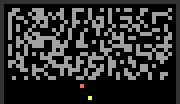

In [56]:
_ = process2(puzzle.input, visualize=True)

## Day 14: Make fuel from ore

Given a list of reactions (integer count of input chemicals necessary to produce count of one output chemical):

- Part 1: Report the amount of `ORE` required to produce 1 `FUEL`.

- Part 2: Given 1 trillion `ORE`, report the maximum amount of `FUEL` that can be produced.

In [57]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2019/day/14), `puzzle.input` has 58 lines:

1 JKXFH => 8 KTRZ
11 TQGT, 9 NGFV, 4 QZBXB => 8 MPGLV
8 NPDPH, 1 WMXZJ => 7 VCNSK
1 MPGLV, 6 CWHX => 5 GDRZ
16 JDFQZ => 2 CJTB
1 GQNQF, 4 JDFQZ => 5 WJKDC
2 TXBS, 4 SMGQW, 7 CJTB, 3 NTBQ, 13 CWHX, 25 FLPFX => 1 FUEL
3 WMXZJ, 14 CJTB => 5 FLPFX
 ...
7 KWCDP => 3 SCKB
6 LGKHR => 8 MKLP
39 MKJDZ => 9 CZSJ
2 TSWN, 1 WMXZJ => 3 PSJL


The stored answers are: `{1: '2486514', 2: '998536'}`

In [58]:
#@title

print('Define s1, s2, s3, s4, s5.')

s1 = """
10 ORE => 10 A
1 ORE => 1 B
7 A, 1 B => 1 C
7 A, 1 C => 1 D
7 A, 1 D => 1 E
7 A, 1 E => 1 FUEL
"""

s2 = """
9 ORE => 2 A
8 ORE => 3 B
7 ORE => 5 C
3 A, 4 B => 1 AB
5 B, 7 C => 1 BC
4 C, 1 A => 1 CA
2 AB, 3 BC, 4 CA => 1 FUEL
"""

s3 = """
157 ORE => 5 NZVS
165 ORE => 6 DCFZ
44 XJWVT, 5 KHKGT, 1 QDVJ, 29 NZVS, 9 GPVTF, 48 HKGWZ => 1 FUEL
12 HKGWZ, 1 GPVTF, 8 PSHF => 9 QDVJ
179 ORE => 7 PSHF
177 ORE => 5 HKGWZ
7 DCFZ, 7 PSHF => 2 XJWVT
165 ORE => 2 GPVTF
3 DCFZ, 7 NZVS, 5 HKGWZ, 10 PSHF => 8 KHKGT
"""

s4 = """
2 VPVL, 7 FWMGM, 2 CXFTF, 11 MNCFX => 1 STKFG
17 NVRVD, 3 JNWZP => 8 VPVL
53 STKFG, 6 MNCFX, 46 VJHF, 81 HVMC, 68 CXFTF, 25 GNMV => 1 FUEL
22 VJHF, 37 MNCFX => 5 FWMGM
139 ORE => 4 NVRVD
144 ORE => 7 JNWZP
5 MNCFX, 7 RFSQX, 2 FWMGM, 2 VPVL, 19 CXFTF => 3 HVMC
5 VJHF, 7 MNCFX, 9 VPVL, 37 CXFTF => 6 GNMV
145 ORE => 6 MNCFX
1 NVRVD => 8 CXFTF
1 VJHF, 6 MNCFX => 4 RFSQX
176 ORE => 6 VJHF
"""

s5 ="""
171 ORE => 8 CNZTR
7 ZLQW, 3 BMBT, 9 XCVML, 26 XMNCP, 1 WPTQ, 2 MZWV, 1 RJRHP => 4 PLWSL
114 ORE => 4 BHXH
14 VRPVC => 6 BMBT
6 BHXH, 18 KTJDG, 12 WPTQ, 7 PLWSL, 31 FHTLT, 37 ZDVW => 1 FUEL
6 WPTQ, 2 BMBT, 8 ZLQW, 18 KTJDG, 1 XMNCP, 6 MZWV, 1 RJRHP => 6 FHTLT
15 XDBXC, 2 LTCX, 1 VRPVC => 6 ZLQW
13 WPTQ, 10 LTCX, 3 RJRHP, 14 XMNCP, 2 MZWV, 1 ZLQW => 1 ZDVW
5 BMBT => 4 WPTQ
189 ORE => 9 KTJDG
1 MZWV, 17 XDBXC, 3 XCVML => 2 XMNCP
12 VRPVC, 27 CNZTR => 2 XDBXC
15 KTJDG, 12 BHXH => 5 XCVML
3 BHXH, 2 VRPVC => 7 MZWV
121 ORE => 7 VRPVC
7 XCVML => 6 RJRHP
5 BHXH, 4 VRPVC => 5 LTCX
"""

Define s1, s2, s3, s4, s5.


In [59]:
def topological_sort(graph, cycle_check=False):
  """Given a DAG (directed acyclic graph), returns a list of graph nodes such
  that for every directed edge (u, v) in the graph, u is before v in the list.
  https://en.wikipedia.org/wiki/Topological_sorting
  https://stackoverflow.com/a/47234034/
  """
  result = []
  seen = set()

  def recurse(node):
    for dependent in reversed(graph[node]):
      if dependent not in seen:
        seen.add(dependent)
        recurse(dependent)
    result.append(node)

  all_dependents = set().union(*graph.values())
  for node in reversed(list(graph)):  # (reversed(graph) in Python 3.8).
    if node not in all_dependents:
      recurse(node)

  if cycle_check:
    position = {node: i for i, node in enumerate(result)}
    for node, dependents in graph.items():
      for dependent in dependents:
        if position[node] < position[dependent]:
          raise ValueError('Graph contains a cycle')

  return result[::-1]


if 0:  # requires python 3.9
  def topological_sort(graph):  # untested
    import graphlib
    return list(graphlib.TopologicalSorter(graph).static_order())


def test():
  graph = {
      'A': ['ORE'],
      'B': ['ORE'],
      'C': ['A', 'B'],
      'D': ['A', 'C'],
      'E': ['A', 'D'],
      'FUEL': ['A', 'E'],
      'ORE': []
  }
  check_eq(topological_sort(graph, cycle_check=True),
           ['FUEL', 'E', 'D', 'C', 'A', 'B', 'ORE'])

test()

In [60]:
def discrete_binary_search(feval, xl, xh, y_desired):
  """Returns x such that feval(x) <= y_desired < feval(x + 1),

  given xl < xh and feval(xl) <= y_desired < feval(xh).
  """
  assert xl < xh
  while xh - xl > 1:
    xm = (xl + xh) // 2
    ym = feval(xm)
    if y_desired >= ym:
      xl = xm
    else:
      xh = xm
  return xl

In [61]:
def ore_from_fuel(s, fuel=1):

  def parse_recipes(s):
    """Returns {output: (quantity_output, Counter(inputs)}."""

    def element_quantity(s):
      quantity, element = re.fullmatch(r'(\d+) (\w+)', s).groups()
      return collections.Counter({element: int(quantity)})

    lines = s.strip().split('\n')
    recipes = {}
    for line in lines:
      s_input, s_output = re.fullmatch(r'([^=]+) => (\d+ \w+)', line).groups()
      input_counters = (element_quantity(s) for s in s_input.split(', '))
      input_counter = functools.reduce(lambda a, b: a + b, input_counters)
      (output_element, quantity_output), = element_quantity(s_output).items()
      recipes[output_element] = (quantity_output, input_counter)
    return recipes

  Counter = collections.Counter
  inputs = Counter({'FUEL': fuel})
  recipes = parse_recipes(s)
  graph = {node: list(counter) for node, (_, counter) in recipes.items()}
  graph['ORE'] = []
  elements_in_order = topological_sort(graph)
  check_eq(elements_in_order[0], 'FUEL')
  check_eq(elements_in_order.pop(), 'ORE')
  for element_needed in elements_in_order:
    quantity_needed = inputs.pop(element_needed)
    quantity_generated, input_counter = recipes[element_needed]
    factor = math.ceil(quantity_needed / quantity_generated)
    inputs += Counter({k: factor * v for k, v in input_counter.items()})
  check_eq(len(inputs), 1)
  quantity = inputs.pop('ORE')
  return quantity


process1 = ore_from_fuel

check_eq(process1(s1), 31)
check_eq(process1(s2), 165)
check_eq(process1(s3), 13312)
check_eq(process1(s4), 180697)
check_eq(process1(s5), 2210736)

puzzle.verify(1, process1)  # ~2 ms.

(Part 1: 0.002 s)


In [62]:
def process2(s, debug=False):
  f = lambda fuel: ore_from_fuel(s, fuel)
  ore_bound = 1_000_000_000_000
  fuel = discrete_binary_search(f, 0, 10_000_000, ore_bound)
  if debug:
    assert ore_bound - 1_000_000 <= f(fuel) < ore_bound
  return fuel

puzzle.verify(2, process2)  # ~43 ms.
_ = process2(puzzle.input, debug=True)

(Part 2: 0.048 s)


## Day 15: Shortest maze path

Given a program controlling a robot, which accepts movement commands (`1`: north, `2`: south, `3`: west, `4`: east) and outputs status (`0`: hit wall, `1`: moved, `2`: reached destination):

- Part 1: Report the fewest number of movement commands to reach the destination.

- Part 2: Simulate oxygen spreading from destination at a speed of one cell per minute.  report the number of minutes to fill all cells.

In [63]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2019/day/15), `puzzle.input` has a single line of 3_341 characters:

3,1033,1008,1033,1,1032,1005,1032,31,1008,1033,2,1032,1005,1032,58,1008,1033,3,1 ... ,31,63,0,0,21,21,1,10,1,0,0,0,0,0,0


The stored answers are: `{1: '218', 2: '544'}`

In [64]:
class ExploreMaze:
  ORIGIN = (0, 0)  # yx
  NEIGHBORS = ((0, 1), (1, 0), (0, -1), (-1, 0))

  # north (1), south (2), west (3), and east (4)
  COMMAND_FOR_MOVEMENT = {(0, 1): 4, (1, 0): 2, (0, -1): 3, (-1, 0): 1}

  def __init__(self, machine_s):
    self.machine = Machine(machine_s)
    self.grid = {}  # {yx: code} with code in '.#' (empty, wall)
    self.current_yx = self.ORIGIN
    self.grid[self.current_yx] = '.'  # empty
    self.destination = None  # not yet found

  def shortest_path(self, src_yx, until='unknown'):
    # Performs a breadth-first search in the known grid from src_yx until either
    # reaching an unknown node or reaching the destination (based on 'until').
    # Returns a list of yx coordinates along the path (not including src_yx),
    # or [] if the search terminates.
    assert until in ('unknown', 'destination')
    seen = {src_yx}
    to_visit = collections.deque([src_yx])
    previous = {}  # {yx: node_yx_which_saw_it}

    while to_visit:
      yx = to_visit.popleft()
      if ((until == 'destination' and yx == self.destination) or
          (until == 'unknown' and yx not in self.grid)):
        path = [yx]
        while yx in previous:
          yx = previous[yx]
          path.append(yx)
        return path[-2::-1]  # omit src_yx
      for neighbor in self.NEIGHBORS:
        yx2 = yx[0] + neighbor[0], yx[1] + neighbor[1]
        if yx2 not in seen and self.grid.get(yx2) != '#':
          seen.add(yx2)
          to_visit.append(yx2)
          previous[yx2] = yx

    return []

  def advance_to(self, yx):
    diff = yx[0] - self.current_yx[0], yx[1] - self.current_yx[1]
    command = self.COMMAND_FOR_MOVEMENT[diff]
    result, = self.machine.run_until_need_input([command])
    assert 0 <= result <= 2
    if result == 0:  # wall
      assert yx not in self.grid
      self.grid[yx] = '#'  # wall
      return False
    self.current_yx = yx
    self.grid[yx] = '.'  # empty
    if result == 2:  # found destination
      self.destination = yx
    return True

  def explore(self):
    while True:
      path = self.shortest_path(self.current_yx, until='unknown')
      if not path:
        break
      for yx in path[:-1]:
        check_eq(self.advance_to(yx), True)
      self.advance_to(path[-1])

  def visualize_grid(self, grid):
    g = grid.copy()
    g[self.ORIGIN] = 'S'
    if self.destination:
      g[self.destination] = 'D'
    # g[self.current_yx] = '@'
    cmap = {
        ' ': (235,) * 3,
        '.': (190,) * 3,
        '#': (20,) * 3,
        'S': (0, 255, 0),
        'D': (255, 0, 0),
        '@': (255, 255, 100),
        'p': (0, 255, 255),
    }
    image = hh.image_from_yx_map(g, background=' ', cmap=cmap, pad=1)
    return image.repeat(4, axis=0).repeat(4, axis=1)

  def compute(self, visualize=False):
    self.explore()
    assert self.destination
    path = self.shortest_path(self.ORIGIN, until='destination')
    if visualize:
      grid = self.grid.copy()
      images = []
      for yx in path:
        grid[yx] = 'p'
        images.append(self.visualize_grid(grid))
      images = [images[0]] * 25 + images + [images[-1]] * 25
      media.show_video(images, codec='gif', fps=25)
    return len(path)

  def farthest_distance_from_destination(self, visualize=False):
    self.compute()
    src_yx = self.destination
    seen = {src_yx}
    to_visit = collections.deque([src_yx])
    previous = {}  # {yx: node_yx_which_saw_it}

    while to_visit:
      yx = to_visit.popleft()
      for neighbor in self.NEIGHBORS:
        yx2 = yx[0] + neighbor[0], yx[1] + neighbor[1]
        if yx2 not in seen and self.grid.get(yx2) != '#':
          seen.add(yx2)
          to_visit.append(yx2)
          previous[yx2] = yx

    grid = self.grid.copy()
    farthest_yx = yx
    distance = 0
    while yx in previous:
      yx = previous[yx]
      distance += 1
    if visualize:
      images = []
      grid[farthest_yx] = 'D'
      yx = farthest_yx
      while yx in previous:
        grid[yx] = 'p'
        yx = previous[yx]
        images.append(self.visualize_grid(grid))
      images = [images[0]] * 25 + images + [images[-1]] * 25
      media.show_video(images, codec='gif', fps=25)
    return distance


def process1(s):
  return ExploreMaze(s).compute()

puzzle.verify(1, process1)  # ~32 ms.

(Part 1: 0.036 s)


""

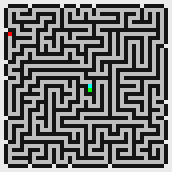

In [65]:
_ = ExploreMaze(puzzle.input).compute(visualize=True)

In [66]:
def process2(s):
  return ExploreMaze(s).farthest_distance_from_destination()

puzzle.verify(2, process2)  # ~36 ms.

(Part 2: 0.062 s)


""

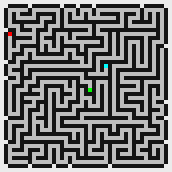

In [67]:
_ = ExploreMaze(puzzle.input).farthest_distance_from_destination(visualize=True)

## Day 16: Fast faulty transform (FFT)

Given a list of numbers, FFT applies `k` phases.  In a phase, each element is replaced by a new value which is the dot product of the whole list with a repeating pattern, modulo 10.  To compute element `i`, the pattern is a base pattern `0, 1, 0, -1` in which each element is repeated `i` times, and the very first `0` pattern value is omitted.

- Part 1: report the first 8 digits after 100 phases of FFT.

- Part 2: Repeat the input list 10_000 times.  After 100 phases of FFT, report the 8 digits at an offset specified by the first 7 input digits.

In [68]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2019/day/16), `puzzle.input` has a single line of 650 characters:

59709511599794439805414014219880358445064269099345553494818286560304063399998657 ... 63060659768372996371503017206185697


The stored answers are: `{1: '34841690', 2: '48776785'}`

In [69]:
s1 = '12345678'

In [70]:
def repeat_each(iterable, n: int):
  """Repeat each element of iterable 'n' times."""
  # https://stackoverflow.com/a/65071833
  return itertools.chain.from_iterable(zip(*itertools.tee(iterable, n)))

check_eq(''.join(itertools.islice(repeat_each(itertools.cycle('abcd'), 4), 30)),
         'aaaabbbbccccddddaaaabbbbccccdd')

In [71]:
def process1(s, num_phases=100, debug=False):

  def get_fft_pattern(n, i):
    pattern = (0, 1, 0, -1)
    pattern = itertools.cycle(pattern)
    pattern = repeat_each(pattern, i + 1)
    pattern = list(itertools.islice(pattern, 1, n + 1))
    return pattern

  def print_fft_patterns(n):
    with np.printoptions(linewidth=1000, threshold=100_000):
      print(np.array([get_fft_pattern(n, i) for i in range(n)]))

  if debug:
    print_fft_patterns(20)
    return

  l = np.array(list(map(int, s.strip('\n'))))
  patterns = np.array([get_fft_pattern(len(l), i) for i in range(len(l))])
  for _ in range(num_phases):
    np.mod(abs(patterns @ l), 10, out=l)
  return ''.join(map(str, map(int, l[:8])))


check_eq(process1(s1, num_phases=4), '01029498')
check_eq(process1(s1, num_phases=100), '23845678')
check_eq(process1('80871224585914546619083218645595'), '24176176')
check_eq(process1('19617804207202209144916044189917'), '73745418')
check_eq(process1('69317163492948606335995924319873'), '52432133')
puzzle.verify(1, process1)  # ~100 ms.

(Part 1: 0.107 s)


Part 2

In [72]:
s2 = '03036732577212944063491565474664'
s3 = '02935109699940807407585447034323'
s4 = '03081770884921959731165446850517'

In [73]:
def test():
  # We notice that the requested offset in the output is always near the end:
  for input in [s2, s3, s4, puzzle.input]:
    index = int(input[:7])
    frac = index / (len(input) * 10_000)
    trailing = len(input) * 10_000 - index
    print(f'index={index:<8} frac={frac:#.4} trailing={trailing}')

test()

index=303673   frac=0.9490 trailing=16327
index=293510   frac=0.9172 trailing=26490
index=308177   frac=0.9631 trailing=11823
index=5970951  frac=0.9172 trailing=539049


In [74]:
# Observation: all the requested output subsequences are near the end,
# where the computations do not involve negative factors!
# Therefore we can work with modulo-10 arithmetic and always consider just
# the trailing digits.

# Observation: we can do the update of each phase using a cumulative sum from
# the rear of the array.  That is efficient enough!
# For 500_000 digits and 100 phases, we can afford to have space complexity
# of 500_000 and time complexity of 50_000_000.

In [75]:
def process2(s, repeat_input=10_000):

  def fft_transform2_helper(l, num_phases=100):
    for phase in range(num_phases):
      np.cumsum(l[::-1], out=l[::-1])
      # As an optimization, we skip the mod() operation for 2 phases.
      # (If we skip more than 2 phases, the numbers overflow int64.)
      if phase % 3 == 0:
        np.mod(l, 10, out=l)
    np.mod(l, 10, out=l)


  if 'numba' in globals():
    @numba_njit(cache=True)
    def fft_transform2_helper(l, num_phases=100):
      mod10 = np.arange(20) % 10
      for _ in range(num_phases):
        total = 0
        for i in range(len(l) - 1, -1, -1):
          # l[i] = total = (l[i] + total) % 10
          l[i] = total = mod10[l[i] + total]

  s = s.strip('\n')
  index = int(s[:7])
  l = list(map(int, s)) * repeat_input
  assert index > len(l) * 0.51  # output is only valid over last half
  l = np.array(l[index:])  # (Setting dtype has no effect on numba performance.)
  fft_transform2_helper(l)
  return ''.join(map(str, l[:8]))


check_eq(process2(s2), '84462026')
check_eq(process2(s3), '78725270')
check_eq(process2(s4), '53553731')
puzzle.verify(2, process2)  # ~260 ms with numba; ~410 ms without numba.

(Part 2: 0.289 s)


In [76]:
# The following is a failed attempt to derive a closed-form solution.
# Let d(i, k) be the digit at position i from the end after k phases.

# Observation: for the desired k=100, multiplication by k results in a zero
# last digit, so some terms can be ignored?

# d(0, k) = d(0, k-1)
#         = d(0, 0)
# The last digit never changes.

# d(1, k) = d(1, k-1) + d(0, k-1)
#         = d(1, k-1) + d(0, 0)
#         = (d(1, k-2) + d(0, 0)) + d(0, 0)
#         = d(1, 0) + k * d(0, 0)
# The next-to-last digit just adds the last digit k times.

# d(2, k) = d(2, k-1) + d(1, k-1) + d(0, k-1)
#         = d(2, k-1) + (d(1, 0) + (k-1) * d(0, 0)) + d(0, 0)
#         = d(2, k-1) + (d(1, 0) + k * d(0, 0))  YES
#         = d(2, k-1) + d(1, k)  useful?
#    or   = (d(2, k-2) + d(1, k-2) + d(0, k-2)) + (d(1, 0) + k * d(0, 0))
#         = d(2, k-2) + (d(1, 0) + (k-2) * d(0, 0)) + d(0, 0) + d(1, 0) + k * d(0, 0)
#         = d(2, k-2) + 2 * d(1, 0) + (k + k - 1) * d(0, 0)
#         = d(2, 0) + k * d(1, 0) + (k*(k+1)/2) * d(0, 0)

# d(3, k) = d(3, k-1) + d(2, k-1) + d(1, k-1) + d(0, k-1)
#         = d(3, k-1) + (d(2, 0) + (k-1) * d(1, 0) + (k*(k-1)/2) * d(0, 0)) + (d(1, 0) + (k-1) * d(0, 0)) + d(0, 0)
#         = d(3, k-1) + d(2, 0) + k * d(1, 0) + (k+1)*k/2 * d(0, 0)
#         = d(3, 0) + k * d(2, 0) + k*(k+1)/2 * d(1, 0) + E * d(0, 0)
#   where E = (((k+1)*k)/2+1) * (k+1)*k/2) / 2 = (k^4 + 2*k^3 + 3*k^2 + 2*k)/8  yuck

#   0 80871224585914546619083218645595
# 100 24176176480919046114038763195595

## Day 17: Robot movement routine

Use the input program to output a 2D map with a self-intersecting scaffold path.

- Part 1: Compute some measurement of the intersections of the 2D path.

- Part 2: Determine the sequence of turn and move instructions for the scaffold path, then encode these into a short routine with instance calls to 3 short subpaths.  Enter the routine and subpaths as input to the program and report some program output.

In [77]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2019/day/17), `puzzle.input` has a single line of 4_943 characters:

1,330,331,332,109,3890,1102,1,1182,16,1102,1471,1,24,101,0,0,570,1006,570,36,100 ... ,36,1,3,1,36,1,3,1,36,1,3,1,36,5,32


The stored answers are: `{1: '7584', 2: '1016738'}`

In [78]:
s1 = """
..#..........
..#..........
#######...###
#.#...#...#.#
#############
..#...#...#..
..#####...^..
"""

In [79]:
def parse_scaffold_grid(s):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1, '^': 2})
  start = tuple(np.array(np.nonzero(grid == 2)).T[0])
  return grid, start

def test():
  grid, start = parse_scaffold_grid(s1)
  print(grid, start)

test()

[[0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0 1 1 1]
 [1 0 1 0 0 0 1 0 0 0 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 1 1 1 1 0 0 0 2 0 0]] (6, 10)


In [80]:
def process1(s):

  def find_intersections(s):
    grid, start = parse_scaffold_grid(s)
    intersections = []
    for y in range(1, grid.shape[0] - 1):
      for x in range(1, grid.shape[1] - 1):
        f = lambda y, x: grid[y, x] != 0
        if (f(y, x) and f(y, x - 1) and f(y, x + 1) and f(y - 1, x) and
            f(y + 1, x)):
          intersections.append((y, x))

    return sum(x * y for y, x in intersections)

  check_eq(find_intersections(s1), 76)

  output = Machine(s).run_fully()
  puzzle_s = ''.join(map(chr, output))
  return find_intersections(puzzle_s)


puzzle.verify(1, process1)  # ~3 ms.

(Part 1: 0.004 s)


Part 2

In [81]:
s2 = """
#######...#####
#.....#...#...#
#.....#...#...#
......#...#...#
......#...###.#
......#.....#.#
^########...#.#
......#.#...#.#
......#########
........#...#..
....#########..
....#...#......
....#...#......
....#...#......
....#####......
"""

(Part 2: 0.018 s)


s_functions = ['R,4,R,12,R,10,L,12', 'L,12,R,4,R,12', 'L,12,L,8,R,10'], s_routine = A,B,B,C,C,A,B,B,C,A


""

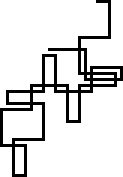

In [82]:
def process2(s, visualize=False):

  def get_robot_input(s):

    def compute_commands(s):
      grid, start = parse_scaffold_grid(s)
      yx = start
      dyx = (-1, 0)  # initial direction is up ('^')

      is_scaffold = lambda yx: grid[yx] == 1
      inbounds = lambda yx: all(0 <= yx[i] < grid.shape[i] for i in range(2))
      inbound_scaffold = lambda yx: inbounds(yx) and is_scaffold(yx)
      turn_left = lambda dyx: (-dyx[1], dyx[0])
      turn_right = lambda dyx: (dyx[1], -dyx[0])

      assert not is_scaffold(tuple(np.array(yx) + dyx))
      commands = []
      current_forward_steps = 0

      while True:
        yx2 = tuple(np.array(yx) + dyx)
        if inbound_scaffold(yx2):
          current_forward_steps += 1
          yx = yx2
          continue

        if current_forward_steps:
          commands.append(str(current_forward_steps))
        current_forward_steps = 0
        dyx_left = turn_left(dyx)
        yx2 = tuple(np.array(yx) + dyx_left)
        left_ok = inbound_scaffold(yx2)

        dyx_right = turn_right(dyx)
        yx2 = tuple(np.array(yx) + dyx_right)
        right_ok = inbound_scaffold(yx2)
        if not left_ok and not right_ok:
          break
        assert not (left_ok and right_ok)
        dyx = (turn_left if left_ok else turn_right)(dyx)
        commands.append('L' if left_ok else 'R')
      return commands

    check_eq(','.join(compute_commands(s2)),
            'R,8,R,8,R,4,R,4,R,8,L,6,L,2,R,4,R,4,R,8,R,8,R,8,L,6,L,2')

    puzzle_s = ''.join(map(chr, Machine(s).run_fully()))
    commands = compute_commands(puzzle_s)
    s_routine = ','.join(commands) + ','
    s_functions = []
    for i in range(3):
      # Skip prefix of '([ABC],)*' and minimize resulting string length.
      skip = len(re.search(r'^([ABC],)*', s_routine).group(0))
      best = 10**8, None, None
      for num_matches in range(2, 10):
        pattern = r'([LR0-9][LR,0-9]+[LR0-9],)' + r'.*\1' * num_matches
        match = re.search(pattern, s_routine[skip:])
        if match:
          group1 = match.group(1)[:-1]
          candidate = s_routine.replace(group1, chr(ord('A') + i))
          best = min(best, (len(candidate), group1, candidate))
      _, group1, candidate = best
      s_functions.append(group1)
      s_routine = candidate
      # hh.show(skip, group1, candidate, s_routine)
    s_routine = s_routine[:-1]  # Remove trailing comma.
    assert not any(s in s_routine for s in 'LR')
    if visualize:
      hh.show(s_functions, s_routine)

    s_video_feed = 'n'
    return list(itertools.chain.from_iterable(
        list(map(ord, s + '\n'))
        for s in ([s_routine] + s_functions + [s_video_feed])))

  robot_input = get_robot_input(s)
  machine = Machine(s)
  check_eq(machine.mem[0], 1)
  machine.mem[0] = 2
  output = machine.run_fully(robot_input)
  if visualize:
    s = ''.join(map(chr, output[:-1]))
    s = s.split('Continuous video feed?')[1].strip('\n')
    # print(s)  # Map confirming that we have reached the end of the path.
    image = (hh.grid_from_string(s) != '.').repeat(3, axis=0).repeat(3, axis=1)
    media.show_image(~image, border=True)
  return output[-1]  # result is the last output element


puzzle.verify(2, process2)  # ~9 ms.
_ = process2(puzzle.input, visualize=True)

## Day 18: Maze with doors and keys

Given a 2D maze with gates and keys, with the property that one may pass a gate only if holding its associated key:

- Part 1: Compute the number of steps for the shortest path that collects all the keys.

In [83]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2019/day/18), `puzzle.input` has 81 lines:

#################################################################################
#.....#.....#z#...C.....#.........#.....#.#.....#.......V.#.....#.........#b....#
###.#.###.#.#.#.#####.###.#.#######.###.#.#.#.#.#.#######.#####.#.#######.#.#.###
#...#..y..#.#.#.#...#.#...#........p#...#...#.#...#.....#.#...T.#...#...#...#...#
#.#.#######.#.#.#.###.#.#############.#.#####.#####.#####.#.#.###.###.#.#.#####H#
#.#.#.....#.#.#.#...#...#..l....#.....#.#...Y.#...#.......#.#.#...#...#.#.....#.#
#.#.#.###.#.#.#.###.#####.###.###.#####.#.#####.###.#######.###.###.###.#######.#
#.#.#.G.#.#...#...#.........#...#.#.....#.#...#...#.#.#.........#...#.#...#.....#
 ...
#...#...#.#...#...#.#.#...#.#...#...#.#.#.....#.......#...#...#.#...#.#.....#...#
#.###.###.#.#.#####.#.###.#.#.#.#####.#.#.#######.###.#.#####.#.#.#.###.###.###.#
#.....#.....#.......#...#...#.#.........#.....U...#.....#.....#...#....h#.......#
#################################################################################


The stored answers are: `{1: '4700', 2: '2260'}`

In [84]:
if 0:
  media.set_max_output_height(3000)
  print(puzzle.input)

In [85]:
#@title
print('Define s1, s2, s3, s4, s5, s11, s12, s13, s14')

s1 = """
#########
#b.A.@.a#
#########
"""

s2 = """
########################
#f.D.E.e.C.b.A.@.a.B.c.#
######################.#
#d.....................#
########################
"""

s3 = """
########################
#...............b.C.D.f#
#.######################
#.....@.a.B.c.d.A.e.F.g#
########################
"""

s4 = """
#################
#i.G..c...e..H.p#
########.########
#j.A..b...f..D.o#
########@########
#k.E..a...g..B.n#
########.########
#l.F..d...h..C.m#
#################
"""

s5 = """
########################
#@..............ac.GI.b#
###d#e#f################
###A#B#C################
###g#h#i################
########################
"""

s11 = """
#######
#a.#Cd#
##...##
##.@.##
##...##
#cB#Ab#
#######
"""

s12 = """
###############
#d.ABC.#.....a#
######@#@######
###############
######@#@######
#b.....#.....c#
###############
"""

s13 = """
#############
#DcBa.#.GhKl#
#.###@#@#I###
#e#d#####j#k#
###C#@#@###J#
#fEbA.#.FgHi#
#############
"""

s14 = """
#############
#g#f.D#..h#l#
#F###e#E###.#
#dCba@#@BcIJ#
#############
#nK.L@#@G...#
#M###N#H###.#
#o#m..#i#jk.#
#############
"""

Define s1, s2, s3, s4, s5, s11, s12, s13, s14


In [86]:
def process1(s):  # Most compact, for part 1 only
  def is_key(ch): return ch.islower() or ch == '@'
  def is_door(ch): return ch.isupper()
  def key_for_door(ch): return ch.lower()
  grid = hh.grid_from_string(s)
  yx_of_key = {ch: yx for yx, ch in np.ndenumerate(grid) if is_key(ch)}
  current_key = '@'

  @functools.lru_cache(maxsize=None)
  def possible_paths(current_key):  # Returns [(key, distance, needed)].
    yx = yx_of_key[current_key]
    to_visit = collections.deque([(0, yx, [])])
    seen = {yx}
    result = []
    while to_visit:
      distance, yx, needed = to_visit.popleft()
      ch = grid[yx]
      if is_key(ch) and ch != current_key:
        result.append((ch, distance, frozenset(needed)))
        needed = needed + [ch]
      elif is_door(ch):
        needed = needed + [key_for_door(ch)]
      for dy, dx in ((0, 1), (0, -1), (1, 0), (-1, 0)):
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          to_visit.append((distance + 1, yx2, needed))
    return result

  @functools.lru_cache(maxsize=None)
  def eligible_paths(current_key, keys):  # Returns [(distance, key)].
    return [(d, key) for key, d, needed in possible_paths(current_key)
            if key not in keys and needed.issubset(keys)]

  @functools.lru_cache(maxsize=None)
  def explore(current_key, keys):  # Returns distance.
    if len(keys) == len(yx_of_key):
      return 0
    return min(path_distance + explore(key, keys.union(key))
               for path_distance, key in eligible_paths(current_key, keys))

  return explore(current_key, frozenset(current_key))


check_eq(process1(s1), 8)  # ~0 ms.
check_eq(process1(s2), 86)  # ~1 ms.
check_eq(process1(s3), 132)  # ~1 ms.
check_eq(process1(s4), 136)  # ~660 ms.
check_eq(process1(s5), 81)  # ~2 ms.
puzzle.verify(1, process1)  # ~1100 ms.

(Part 1: 0.567 s)


In [87]:
def process1(s, part2=False,
             visualize=False, fps=50, size=4, speed=1, tail=1):
  def is_key(ch): return ch.islower() or ch in '0123'
  def is_door(ch): return ch.isupper()
  def key_for_door(ch): return ch.lower()
  grid = hh.grid_from_string(s)
  if part2 and np.sum(grid == '@') == 1:
    (y, x), = np.argwhere(grid == '@')
    assert np.all(grid[[y, y, y-1, y+1], [x-1, x+1, x, x]] == '.')
    grid[[y, y, y, y-1, y+1], [x, x-1, x+1, x, x]] = '#'
    grid[[y-1, y-1, y+1, y+1], [x-1, x+1, x-1, x+1]] = '@'
  current_keys = tuple(str(i) for i in range(np.sum(grid == '@')))
  grid[grid == '@'] = current_keys
  yx_of_key = {ch: yx for yx, ch in np.ndenumerate(grid) if is_key(ch)}

  @functools.lru_cache(maxsize=None)
  def possible_paths(current_key):  # Returns {key: (distance, needed, path)}.
    yx = yx_of_key[current_key]
    to_visit = collections.deque([(0, yx, [])])
    seen = {yx}
    parent = {}
    result = {}
    while to_visit:
      distance, yx, needed = to_visit.popleft()
      ch = grid[yx]
      if is_key(ch) and ch != current_key:
        path = []
        yx2 = yx
        while yx2:
          path.append(yx2)
          yx2 = parent.get(yx2, None)
        result[ch] = (distance, frozenset(needed), path[::-1])
        needed = needed + [ch]
      elif is_door(ch):
        needed = needed + [key_for_door(ch)]
      for dy, dx in ((0, 1), (0, -1), (1, 0), (-1, 0)):
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          parent[yx2] = yx
          to_visit.append((distance + 1, yx2, needed))
    return result

  @functools.lru_cache(maxsize=None)
  def eligible_paths(current_key, keys):  # Returns [(distance, key)].
    items = possible_paths(current_key).items()
    return [(d, key) for key, (d, needed, _) in items
            if key not in keys and needed.issubset(keys)]

  @functools.lru_cache(maxsize=None)
  def move(current_keys, i, key):
    t = list(current_keys)
    t[i] = key
    return tuple(t)

  @functools.lru_cache(maxsize=None)
  def explore(current_keys, keys):  # Returns (distance, index_key, next_key).
    if len(keys) == len(yx_of_key):
      return 0, None, None
    best = 10**8, None, None
    for index_key, current_key in enumerate(current_keys):
      for path_distance, key in eligible_paths(current_key, keys):
        current_keys2 = move(current_keys, index_key, key)
        keys2 = keys.union(key)
        candidate_distance = path_distance + explore(current_keys2, keys2)[0]
        if candidate_distance < best[0]:
          best = candidate_distance, index_key, key
    return best

  distance, _, _ = explore(current_keys, frozenset(current_keys))

  if visualize:
    grid[(grid >= '0') & (grid <= '9')] = '.'
    cmap = {'.': (240,) * 3, '#': (40,) * 3,
            **{chr(ch): (255, 0, 0) for ch in range(ord('a'), ord('z') + 1)},
            **{chr(ch): (0, 180, 0) for ch in range(ord('A'), ord('Z') + 1)}}
    images = []
    keys = frozenset(current_keys)
    owned_key_color = (255, 160, 160)
    active_color = (250, 120, 0)
    while True:
      image = np.array([cmap[e] for e in grid.flat], dtype=np.uint8).reshape(
          *grid.shape, 3)
      for key in keys.difference('0123'):
        image[yx_of_key[key]] = owned_key_color
      for key in current_keys:
        image[yx_of_key[key]] = active_color
      for yx, ch in np.ndenumerate(grid):
        if is_door(ch) and key_for_door(ch) in keys:
          image[yx] = (130, 255, 130)  # Opened door.
      distance, index_key, key = explore(current_keys, keys)
      if distance == 0:
        images.append(image.repeat(size, axis=0).repeat(size, axis=1))
        break
      keys = keys.union(key)
      src_key, dst_key = current_keys[index_key], key
      path = possible_paths(src_key)[dst_key][2]
      image[path[0]] = owned_key_color
      for i in range(len(path)):
        yx = path[i]
        if grid[yx] == '.':
          image[yx] = active_color
        if i >= tail:
          yx = path[i - tail]
          if grid[yx] == '.':
            image[path[i - tail]] = cmap['.']
        if (i - 1) % speed == 0:
          images.append(image.repeat(size, axis=0).repeat(size, axis=1))
      current_keys = move(current_keys, index_key, key)

    images = [images[0]] * (2 * fps) + images + [images[-1]] * (2 * fps)
    media.show_video(images, codec='gif', fps=fps)

  return distance


check_eq(process1(s1), 8)  # ~0 ms.
check_eq(process1(s2), 86)  # ~1 ms.
check_eq(process1(s3), 132)  # ~1 ms.
check_eq(process1(s4), 136)  # ~150 ms.
check_eq(process1(s5), 81)  # ~2 ms.
puzzle.verify(1, process1)  # ~500 ms.

process2 = functools.partial(process1, part2=True)
check_eq(process2(s11), 8)  # ~0 ms.
check_eq(process2(s12), 24)  # ~0 ms.
check_eq(process2(s13), 32)  # ~1 ms.
check_eq(process2(s14), 72)  # ~3 ms.
puzzle.verify(2, process2)  # ~500 ms.

(Part 1: 0.485 s)
(Part 2: 0.571 s)


""


""

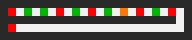

""

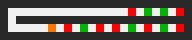

""

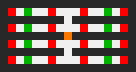

""

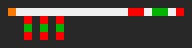

In [88]:
_ = process1(s1, visualize=True, size=8, fps=10)
_ = process1(s2, visualize=True, size=8, fps=10)
_ = process1(s3, visualize=True, size=8, fps=10)
_ = process1(s4, visualize=True, size=8, fps=10)
_ = process1(s5, visualize=True, size=8, fps=10)

""

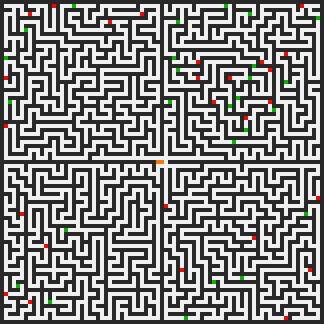

In [89]:
_ = process1(puzzle.input, visualize=True, speed=3, tail=2)  # ~12 s.

""

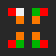

""

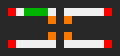

""

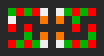

""

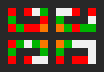

In [90]:
_ = process2(s11, visualize=True, size=8, fps=4)
_ = process2(s12, visualize=True, size=8, fps=4)
_ = process2(s13, visualize=True, size=8, fps=4)
_ = process2(s14, visualize=True, size=8, fps=4)

""

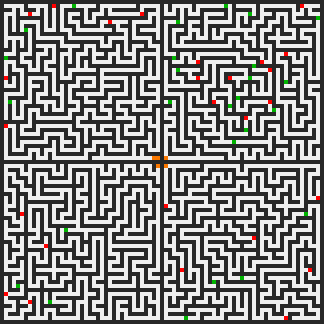

In [91]:
_ = process2(puzzle.input, visualize=True, speed=2, tail=2)  # ~12 s.

## Day 19: Tractor beam region

Given a program that reports for a given `(x, y)` points whether a tractor beam is active:

- Part 1: Count the number of points affected by the tractor beam in the square `[0, 49] x [0, 49]`.

- Part 2: Determine the `100x100` square closest to the origin that is entirely within the tractor beam.  Report the upper-left corner `x, y` of the square, as `10_000 * x + y`.

In [92]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2019/day/19), `puzzle.input` has a single line of 1_465 characters:

109,424,203,1,21102,1,11,0,1106,0,282,21101,18,0,0,1105,1,259,2102,1,1,221,203,1 ... 3,-2,1,21201,1,0,-4,109,-5,2106,0,0


The stored answers are: `{1: '169', 2: '7001134'}`

(Part 1: 0.376 s)


""

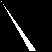

In [93]:
def process1(s, shape=(50, 50), visualize=False):

  def in_tractor(y, x):
    output, = Machine(s).run_fully([x, y])
    assert output in (0, 1)
    return output == 1

  array = np.fromfunction(np.vectorize(in_tractor), (50, 50))
  if visualize:
    media.show_image(np.pad(array, 1), height=100)
  return np.count_nonzero(array)


puzzle.verify(1, process1)  # ~340 ms with Machine_numba; ~3400 ms without.
_ = process1(puzzle.input, visualize=True)

In [94]:
def process2(s, size=100, visualize=False):

  def in_tractor(y, x):
    output, = Machine(s).run_fully([x, y])
    assert output in (0, 1)
    return output == 1

  y = 300
  row_y = np.array([in_tractor(y, x) for x in range(y)])
  xmin, xmax = row_y.nonzero()[0][[0, -1]]
  map_xmax = {}
  yxmap = {(0, 0): 'T'}

  while True:
    y += 1

    # assert not in_tractor(y, xmin - 1)
    while not in_tractor(y, xmin):
      xmin += 1

    # assert in_tractor(y, xmax)
    while in_tractor(y, xmax + 1):
      xmax += 1

    map_xmax[y] = xmax
    yxmap[y, xmin] = yxmap[y, xmax] = '#'

    x_upper_right = map_xmax.get(y - size + 1, 0)
    # print(f'y={y:<6} xmin={xmin:<6} xmax={xmax:<6} ur={x_upper_right}')
    if xmin + size - 1 <= x_upper_right:
      x, y = xmin, y - size + 1  # upper-left of square
      if visualize:
        for dy, dx in np.ndindex((size, size)):
          yxmap[y + dy, x + dx] = 'O'
        cmap = {' ': (240,) * 3, 'T': (255, 0, 0),
                '#': (64,) * 3, 'O': (192,) * 3}
        image = hh.image_from_yx_map(yxmap, background=' ', cmap=cmap, pad=4)
        new_shape = tuple(int(image.shape[c] * 0.25) for c in range(2))
        image = media.resize_image(image, new_shape)
        media.show_image(image)
      return x * 10_000 + y


puzzle.verify(2, process2)  # ~470 ms with Machine_numba; ~4.4 s without.

(Part 2: 0.526 s)


""

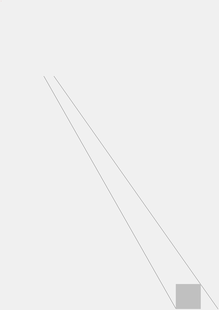

In [95]:
_ = process2(puzzle.input, visualize=True)  # Slow; ~3.8 s.

## Day 20: Maze with recursive portals

Given a "donut" maze with portals connecting some inner openings with some outer openings:

- Part 1: Find the length of the shortest path from entrance `AA` to exit `ZZ`.

- Part 2: The maze is recursive.  At the main level, it has no outer openings (other than `AA` and `ZZ`).  At each level, the inner portals connect to the outer portals of a new instance of the maze (at a "deeper level").  Find the path length from `AA` to `ZZ`.

In [96]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2019/day/20), `puzzle.input` has 125 lines:

                                         J       L   P           P   V T       X ...                                    
                                         G       V   M           I   O R       C ...                                    
  #######################################.#######.###.###########.###.#.#######. ... #################################  
  #...#.........#.#...#.#...#.........#.....#.#.....#.......#...#...#.....#.#... ... #...........#.......#...#.......#  
  ###.#########.#.#.###.#.#######.###.###.###.#####.#.###.###.#####.###.###.#### ... ###.#####.###.#.#####.#####.#####  
  #.#.....#...........#...#...#.#.#.....#.....#.#...#.#.....#.#.#.....#.....#... ... #.......#.#...#.....#.#.#.....#.#  
  #.#####.#####.###.#####.###.#.#######.#.#.###.#.#####.###.#.#.#.#########.#.#. ... ###.#######.#.#######.#.###.###.#  
  #...#...#.....#...#.#...#.#.#...#.#.....#.#.......#...#.#.#...#.#.#.......#.#. ... ........#.#.#.........#.#.#.....#  
 ...
  #...............#.....#..

The stored answers are: `{1: '570', 2: '7056'}`

In [97]:
#@title
s1 = """
         A           EOL
         A           EOL
  #######.#########  EOL
  #######.........#  EOL
  #######.#######.#  EOL
  #######.#######.#  EOL
  #######.#######.#  EOL
  #####  B    ###.#  EOL
BC...##  C    ###.#  EOL
  ##.##       ###.#  EOL
  ##...DE  F  ###.#  EOL
  #####    G  ###.#  EOL
  #########.#####.#  EOL
DE..#######...###.#  EOL
  #.#########.###.#  EOL
FG..#########.....#  EOL
  ###########.#####  EOL
             Z       EOL
             Z       EOL
""".replace('EOL', '')

s2 = """
                   A               EOL
                   A               EOL
  #################.#############  EOL
  #.#...#...................#.#.#  EOL
  #.#.#.###.###.###.#########.#.#  EOL
  #.#.#.......#...#.....#.#.#...#  EOL
  #.#########.###.#####.#.#.###.#  EOL
  #.............#.#.....#.......#  EOL
  ###.###########.###.#####.#.#.#  EOL
  #.....#        A   C    #.#.#.#  EOL
  #######        S   P    #####.#  EOL
  #.#...#                 #......VTEOL
  #.#.#.#                 #.#####  EOL
  #...#.#               YN....#.#  EOL
  #.###.#                 #####.#  EOL
DI....#.#                 #.....#  EOL
  #####.#                 #.###.#  EOL
ZZ......#               QG....#..ASEOL
  ###.###                 #######  EOL
JO..#.#.#                 #.....#  EOL
  #.#.#.#                 ###.#.#  EOL
  #...#..DI             BU....#..LFEOL
  #####.#                 #.#####  EOL
YN......#               VT..#....QGEOL
  #.###.#                 #.###.#  EOL
  #.#...#                 #.....#  EOL
  ###.###    J L     J    #.#.###  EOL
  #.....#    O F     P    #.#...#  EOL
  #.###.#####.#.#####.#####.###.#  EOL
  #...#.#.#...#.....#.....#.#...#  EOL
  #.#####.###.###.#.#.#########.#  EOL
  #...#.#.....#...#.#.#.#.....#.#  EOL
  #.###.#####.###.###.#.#.#######  EOL
  #.#.........#...#.............#  EOL
  #########.###.###.#############  EOL
           B   J   C               EOL
           U   P   P               EOL
""".replace('EOL', '')

s3 = """
             Z L X W       C                 EOL
             Z P Q B       K                 EOL
  ###########.#.#.#.#######.###############  EOL
  #...#.......#.#.......#.#.......#.#.#...#  EOL
  ###.#.#.#.#.#.#.#.###.#.#.#######.#.#.###  EOL
  #.#...#.#.#...#.#.#...#...#...#.#.......#  EOL
  #.###.#######.###.###.#.###.###.#.#######  EOL
  #...#.......#.#...#...#.............#...#  EOL
  #.#########.#######.#.#######.#######.###  EOL
  #...#.#    F       R I       Z    #.#.#.#  EOL
  #.###.#    D       E C       H    #.#.#.#  EOL
  #.#...#                           #...#.#  EOL
  #.###.#                           #.###.#  EOL
  #.#....OA                       WB..#.#..ZHEOL
  #.###.#                           #.#.#.#  EOL
CJ......#                           #.....#  EOL
  #######                           #######  EOL
  #.#....CK                         #......ICEOL
  #.###.#                           #.###.#  EOL
  #.....#                           #...#.#  EOL
  ###.###                           #.#.#.#  EOL
XF....#.#                         RF..#.#.#  EOL
  #####.#                           #######  EOL
  #......CJ                       NM..#...#  EOL
  ###.#.#                           #.###.#  EOL
RE....#.#                           #......RFEOL
  ###.###        X   X       L      #.#.#.#  EOL
  #.....#        F   Q       P      #.#.#.#  EOL
  ###.###########.###.#######.#########.###  EOL
  #.....#...#.....#.......#...#.....#.#...#  EOL
  #####.#.###.#######.#######.###.###.#.#.#  EOL
  #.......#.......#.#.#.#.#...#...#...#.#.#  EOL
  #####.###.#####.#.#.#.#.###.###.#.###.###  EOL
  #.......#.....#.#...#...............#...#  EOL
  #############.#.#.###.###################  EOL
               A O F   N                     EOL
               A A D   M                     EOL
""".replace('EOL', '')

print('Defining inputs s1, s2, and s3.')

Defining inputs s1, s2, and s3.


In [98]:
if 0:
  media.set_max_output_height(3000)
  print(puzzle.input)

In [99]:
def process1(s, part2=False, max_level=0, visualize=False, speed=2, repeat=3):

  class Maze:
    NEIGHBORS = ((0, 1), (1, 0), (0, -1), (-1, 0))

    def __init__(self, s):
      lines = s.strip('\n').split('\n')
      self.grid = grid = np.array(list(map(list, lines)))
      h, w = grid.shape
      hole = hh.bounding_slices(grid[2:-2, 2:-2] == ' ')
      hole = tuple(slice(s.start + 2, s.stop + 2) for s in hole)

      self.yx_of_portal = {0: {}, 1: {}}  # [is_inner][name] -> yx
      self.portal_at_yx = {}  # [yx] -> name

      def look_for_portal(inner, yx, name):
        if name.isalpha():
          self.portal_at_yx[yx] = name
          assert inner == self.is_inner_portal(yx)
          self.yx_of_portal[inner][name] = yx

      for y in range(h):
        look_for_portal(0, (y, 2), grid[y, 0] + grid[y, 1])
        look_for_portal(0, (y, w - 3), grid[y, w - 2] + grid[y, w - 1])
      for x in range(w):
        look_for_portal(0, (2, x), grid[0, x] + grid[1, x])
        look_for_portal(0, (h - 3, x), grid[h - 2, x] + grid[h - 1, x])
      for y in range(hole[0].start, hole[0].stop):
        x = hole[1].start - 1
        look_for_portal(1, (y, x), grid[y, x + 1] + grid[y, x + 2])
        x = hole[1].stop
        look_for_portal(1, (y, x), grid[y, x - 2] + grid[y, x - 1])
      for x in range(hole[1].start, hole[1].stop):
        y = hole[0].start - 1
        look_for_portal(1, (y, x), grid[y + 1, x] + grid[y + 2, x])
        y = hole[0].stop
        look_for_portal(1, (y, x), grid[y - 2, x] + grid[y - 1, x])

      assert all(name in self.yx_of_portal[0] for name in ('AA', 'ZZ'))
      assert not any(name in self.yx_of_portal[1] for name in ('AA', 'ZZ'))
      assert len(self.yx_of_portal[0]) == len(self.yx_of_portal[1]) + 2
      assert not any(self.is_inner_portal(yx)
                    for yx in self.yx_of_portal[0].values())
      assert all(self.is_inner_portal(yx) for yx in self.yx_of_portal[1].values())

      self.portal_portal_path = {}  # [yx][yx2] -> path
      for unused_inner, d in self.yx_of_portal.items():
        for unused_name, src_yx in d.items():
          self.portal_portal_path[src_yx] = self.compute_portal_paths(src_yx)

    def compute_portal_paths(self, src_yx):
      to_visit = collections.deque([src_yx])
      distance = {src_yx: 0}  # for Dijkstra
      parent = {}
      portal_paths = {}  # [yx] -> path

      while to_visit:
        yx = to_visit.popleft()  # Heap not needed because all edge costs are 1.
        for dy, dx in self.NEIGHBORS:
          yx2 = yx[0] + dy, yx[1] + dx
          if yx2 not in distance and self.grid[yx2] == '.':
            distance[yx2] = distance[yx] + 1
            parent[yx2] = yx
            if yx2 in self.portal_at_yx:
              yx3 = yx2
              path = []
              while yx3:
                path.append(yx3)
                yx3 = parent.get(yx3, None)
              portal_paths[yx2] = path[-2::-1]  # Omit src_yx.
            else:
              to_visit.append(yx2)
      return portal_paths

    def is_inner_portal(self, yx) -> int:
      assert yx in self.portal_at_yx
      return int(not any(yx[i] in (2, self.grid.shape[i] - 3) for i in range(2)))

    def opposite_portal(self, lyx, max_level):
      inner = self.is_inner_portal(lyx[1:])
      name = self.portal_at_yx[lyx[1:]]
      yx2 = self.yx_of_portal[1 - inner].get(name)
      l2 = lyx[0] + (0 if max_level == 0 else +1 if inner else -1)
      return (l2, *yx2) if yx2 and 0 <= l2 <= max_level else None

    # Slow version that walks one grid node at a time:
    def shortest_path(self, max_level=sys.maxsize):
      src_lyx = (0, *self.yx_of_portal[0]['AA'])  # (level, y, x)
      dst_lyx = (0, *self.yx_of_portal[0]['ZZ'])
      to_visit = collections.deque([src_lyx])
      distance = collections.defaultdict(lambda: sys.maxsize)  # for Dijkstra
      distance[src_lyx] = 0
      parent = {}

      while to_visit:
        lyx = to_visit.popleft()  # Heap not needed because all edge costs are 1.
        if lyx == dst_lyx:
          path = []
          while lyx:
            path.append(lyx)
            lyx = parent.get(lyx, None)
          return path[-2::-1]  # (The path does not include src_lyx.)
        for dy, dx in self.NEIGHBORS:
          lyx2 = lyx[0], lyx[1] + dy, lyx[2] + dx
          if self.grid[lyx2[1:]].isalpha():
            lyx2 = self.opposite_portal(lyx, max_level)
            if lyx2 is None:
              continue
          elif self.grid[lyx2[1:]] != '.':
            continue
          candidate_d = distance[lyx] + 1
          if candidate_d < distance[lyx2]:
            distance[lyx2] = candidate_d
            parent[lyx2] = lyx
            to_visit.append(lyx2)
      return None  # Could not find path reaching exit.

    # Fast version that jumps across precomputed intra-level shortest paths:
    def shortest_path(self, max_level):
      # Example: https://bradfieldcs.com/algos/graphs/dijkstras-algorithm/
      src_lyx = (0, *self.yx_of_portal[0]['AA'])  # (level, y, x)
      dst_lyx = (0, *self.yx_of_portal[0]['ZZ'])
      pq = [(0, src_lyx)]
      distance = collections.defaultdict(lambda: sys.maxsize)  # for Dijkstra
      distance[src_lyx] = 0
      parent = {}

      while pq:
        d, lyx = heapq.heappop(pq)
        if lyx == dst_lyx:
          path = []
          while True:
            lyx2 = parent.get(lyx, None)
            if not lyx2:
              return path[::-1]  # (The path does not include src_lyx.)
            if lyx[1:] in self.portal_portal_path[lyx2[1:]]:
              subpath = self.portal_portal_path[lyx2[1:]][lyx[1:]][::-1]
              path.extend((lyx[0], *yx) for yx in subpath)
            else:
              check_eq(self.opposite_portal(lyx2, max_level), lyx)
              path.append(lyx2)
            lyx = lyx2

        # Nodes can get added to the priority queue multiple times.  We only
        # process a node the first time we remove it from the priority queue.
        # However, it has no effect on execution time.
        # if d > distance[lyx]:
        #   continue

        # Consider neighbors within level:
        for yx2, path in self.portal_portal_path[lyx[1:]].items():
          lyx2 = (lyx[0], *yx2)
          candidate_d2 = d + len(path)
          if candidate_d2 < distance[lyx2]:
            distance[lyx2] = candidate_d2
            heapq.heappush(pq, (candidate_d2, lyx2))
            parent[lyx2] = lyx

        # Consider the neighbor across the portal:
        lyx2 = self.opposite_portal(lyx, max_level)
        if lyx2:
          candidate_d2 = d + 1
          if candidate_d2 < distance[lyx2]:
            distance[lyx2] = candidate_d2
            heapq.heappush(pq, (candidate_d2, lyx2))
            parent[lyx2] = lyx

      return None  # Could not find path reaching exit.

    def visualize(self, max_level):
      images = []
      src_lyx = (0, *self.yx_of_portal[0]['AA'])
      path = [src_lyx] + self.shortest_path(max_level)
      grid = self.grid.copy()
      grid[('A' <= grid) & (grid <= 'Z')] = 'A'
      cmap = {' ': (235,) * 3, '.': (255,) * 3, '#': (30,) * 3,
              'A': (40, 40, 255)}
      image0 = np.array([cmap[e] for e in grid.flat], dtype=np.uint8).reshape(
        *grid.shape, 3)
      def record_image(image):
        images.append(image.repeat(repeat, axis=0).repeat(repeat, axis=1))
      image = image0.copy()
      count = 0
      level = 0
      last_lyx = src_lyx
      color = (255, 40, 40)
      for lyx in path:
        if lyx[0] == level:
          image[lyx[1:]] = color
          if abs(lyx[1] - last_lyx[1]) + abs(lyx[2] - last_lyx[2]) > 1:
            count = 0  # Jump across portal without level change.
            lyx2 = self.opposite_portal(last_lyx, max_level)
            image[lyx2[1:]] = color
          if count % speed == 0:
            record_image(image)
          count += 1
        else:
          record_image(image)
          image = image0.copy()
          level = lyx[0]
          count = 0
          color = ((255, 40, 40) if self.is_inner_portal(last_lyx[1:])
                  else (0, 180, 60))
          lyx2 = self.opposite_portal(last_lyx, max_level)
          image[lyx2[1:]] = color
          yx2 = next(iter(self.portal_portal_path[lyx2[1:]].values()))[0]
          image[yx2] = color
        last_lyx = lyx
      record_image(image)
      images = [images[0]] * 50 + images + [images[-1]] * 120
      images += [images[0] * 0] * 10
      media.show_video(images, codec='gif', fps=50)

  if part2:
    max_level=sys.maxsize
  if visualize:
    return Maze(s).visualize(max_level)
  path = Maze(s).shortest_path(max_level)
  return len(path) if path else None


check_eq(process1(s1), 23)
check_eq(process1(s2), 58)
check_eq(process1(s2, max_level=100), None)  # ~18 ms.
puzzle.verify(1, process1)  # ~40 ms; ~65 ms without portal_portal_path.

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 26)  # quick test of part2
check_eq(process2(s3), 396)
puzzle.verify(2, process2)  # ~70 ms; ~3450 ms without portal_portal_path.

(Part 1: 0.043 s)
(Part 2: 0.079 s)


""

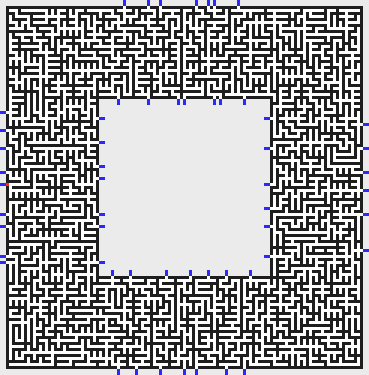

In [100]:
_ = process1(puzzle.input, visualize=True, speed=1)  # Slow: ~4 s.

""

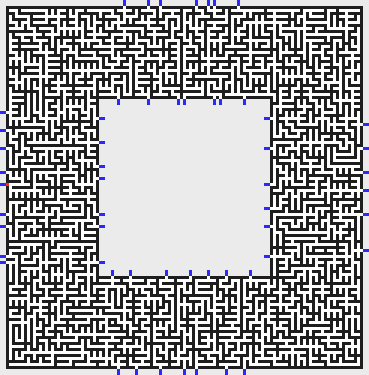

In [101]:
_ = process2(puzzle.input, visualize=True, speed=2)  # Slow: ~25 s.

In [102]:
# See also visualizations in:
# https://www.reddit.com/user/seligman99/comments/ed7vee/day_20_running_through_the_depths_of_the_maze/
# https://kufii.github.io/Advent-Of-Code-2019-Solutions/
#  https://github.com/kufii/Advent-Of-Code-2019-Solutions/blob/master/src/solutions/20/index.js
#  Javascript code: https://imgur.com/NigyhsF

## Day 21: Program jumping robot

Given an Intcode program for a jumping robot, provide as input a Springscript program to probe for holes in the ground and jump at the appropriate time.  Springscript has three instructions (`AND`, `OR`, and `NOT`), two registers (`T` and `J`), and two read-only input registers (`A`, `B`, `C`, and `D` that report `true` if there is ground at distance `1..4`).

- Part 1: Report the sum of output values from the successfully jumping robot.

- Part 2: The robot has increased sensor range (with registers `E`..`I`).  Report a sum of output as before.

In [103]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2019/day/21), `puzzle.input` has a single line of 7_326 characters:

109,2050,21101,0,966,1,21102,1,13,0,1105,1,1378,21102,1,20,0,1105,1,1337,21101,0 ... 1,-3,22201,-5,-3,-5,109,-6,2105,1,0


The stored answers are: `{1: '19348359', 2: '1140850168'}`

In [104]:
def process_springscript(s, spring_program, verbose=False, command='WALK'):
  spring_program = spring_program.lstrip('\n') + command + '\n'
  input = list(map(ord, spring_program))
  output = Machine(s).run_fully(input)
  value = output.pop() if output[-1] >= 128 else None
  last_moments = ''.join(map(chr, output))
  if verbose:
    print(last_moments)
  return value

In [105]:
# Both T and J are initially false.
# If jumping, the robot lands at cell +4.

In [106]:
# Success: Jump if there is ground at D and any of A,B,C are hole:
# J = D AND NOT (A AND B AND C)
spring_program = """
OR  A T
AND B T
AND C T
NOT T J
AND D J
"""
process1 = functools.partial(process_springscript,
                             spring_program=spring_program)

puzzle.verify(1, process1)  # ~2 ms.

(Part 1: 0.003 s)


In [107]:
if 1:
  def test(*args, **kwargs):
    return process_springscript(puzzle.input, *args, **kwargs)

  # Never jump: empty program
  check_eq(test("""
  """), None)

  # Always jump: J = NOT J
  check_eq(test("""
  NOT J J
  """), None)

  # Wait for the last moment to jump: J = (NOT A)
  check_eq(test("""
  NOT A J
  """), None)

  # Jump if there is ground at D (+4): J = D
  check_eq(test("""
  NOT D T
  NOT T J
  """), None)

  # Jump if there is ground at D unless both A and B are ground:
  # J = D AND NOT (A AND B)
  check_eq(test("""
  OR  A T
  AND B T
  NOT T J
  AND D J
  """), None)

Part 2

In [108]:
if 1:
  def test(*args, **kwargs):
    return process_springscript(puzzle.input, *args, **kwargs, command='RUN')
  # The jump is still +4.  Only the sensor range is different (A-I).

  # Previous algorithm: Jump if there is ground at D and any of A,B,C are hole:
  # J = D AND NOT (A AND B AND C)
  check_eq(
      test("""
OR  A T
AND B T
AND C T
NOT T J
AND D J
  """), None)

In [109]:
# Jump if there is ground at D and any of A,B,C are hole, except if E and H are holes.
# J = D AND NOT (A AND B AND C) AND NOT (NOT E and NOT H)
# J = D AND NOT (A AND B AND C) AND (E OR H)
spring_program = """
OR  A T
AND B T
AND C T
NOT T J
AND D J
NOT E T
NOT T T
OR  H T
AND T J
"""
process2 = functools.partial(process_springscript,
                             spring_program=spring_program, command='RUN')

puzzle.verify(2, process2)  # ~16 ms with Machine_numba; ~2400 ms without.

(Part 2: 0.013 s)


## Day 22: Card-deck shuffle

Given a deck of cards labeled `0..10006`, apply the shuffling instructions in the input, consisting of `deal_into_new_deck` (reverse), `cut_n_cards` (rotate), and `deal_with_increment_n` (scatter at regular interval).

- Part 1: After shuffling, report the position of card `2019`.

- Part 2: Consider instead a deck of 119315717514047 cards, and apply the complete shuffle process 101741582076661 times in a row.  Report the card that ends up in position `2020`.

In [110]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2019/day/22), `puzzle.input` has 100 lines:

deal into new stack
deal with increment 68
cut 4888
deal with increment 44
cut -7998
deal into new stack
cut -5078
deal with increment 26
 ...
deal with increment 24
cut -3537
deal with increment 41
deal into new stack


The stored answers are: `{1: '5169', 2: '74258074061935'}`

In [111]:
deck10_shuffles = [
    """
deal with increment 7
deal into new stack
deal into new stack
Result: 0 3 6 9 2 5 8 1 4 7
""",
    """
cut 6
deal with increment 7
deal into new stack
Result: 3 0 7 4 1 8 5 2 9 6
""",
    """
deal with increment 7
deal with increment 9
cut -2
Result: 6 3 0 7 4 1 8 5 2 9
""",
    """
deal into new stack
cut -2
deal with increment 7
cut 8
cut -4
deal with increment 7
cut 3
deal with increment 9
deal with increment 3
cut -1
Result: 9 2 5 8 1 4 7 0 3 6
""",
]

In [112]:
# Old version that keeps a list of cards:
class Deck:

  def __init__(self, arg):
    self.deck = list(range(int(arg))) if isinstance(arg, int) else list(arg)

  def cards(self):
    return self.deck

  def card_at_position(self, pos):
    return self.deck[pos]

  def position_of_card(self, i):
    return self.deck.index(i)

  def deal_into_new_stack(self):
    return Deck(reversed(self.deck))

  def cut_n_cards(self, n):
    n = n % len(self.deck)
    return Deck(self.deck[n:] + self.deck[:n])

  def deal_with_increment(self, n):
    size = len(self.deck)
    assert size % n > 0
    new_deck = [None] * size
    position = 0
    for i in range(size):
      new_deck[position] = self.deck[i]
      position = (position + n) % size
    return Deck(new_deck)

In [113]:
# New version that keeps start and step.  Because the size of the card deck
# is prime, the shuffle deck can be represented as:
# (1) the position of card 0, and
# (2) the offset of card 1 relative to card 0, as 0 <= value < deck_size
# (This is similar to np.ndarray view with data and strides)
@dataclasses.dataclass
class Deck:
  size: int  # number of cards in deck
  start: int = 0  # zero-based position of card 0
  step: int = 1  # position of card 1 relative to card 0

  def __post_init__(self):
    assert math.gcd(self.step, self.size) == 1
    self.start %= self.size
    self.step %= self.size

  def cards(self):
    return [self.card_at_position(pos) for pos in range(self.size)]

  def card_at_position(self, pos):
    assert 0 <= pos < self.size
    # We solve for the card i that satisfies:
    #   pos == (start + step * i) % size   (with gcd(step, size) == 1)
    inv_step = hh.modular_inverse(self.step, self.size)
    # inv_step = pow(self.step, -1, mod=self.size)  # Python 3.8
    return (inv_step * (pos - self.start)) % self.size

  def position_of_card(self, i):
    assert 0 <= i < self.size
    return (self.start + self.step * i) % self.size

  def deal_into_new_stack(self):
    return Deck(self.size, -1 - self.start, -self.step)

  def cut_n_cards(self, n):
    return Deck(self.size, self.start - n, self.step)

  def deal_with_increment(self, n):
    assert self.size % n > 0
    return Deck(self.size, self.start * n, self.step * n)

  def copy(self):
    return dataclasses.replace(self)

  def __mul__(self, other):
    return Deck(self.size, self.start + self.step * other.start,
                 self.step * other.step)

  def __pow__(self, exponent):
    x = Deck(self.size)
    base = self.copy()
    while exponent > 0:
      if exponent % 2 == 1:
        x = (x * base)
      base = (base * base)
      exponent //= 2
    return x

  def apply_shuffle(self, shuffle):
    for line in shuffle.strip('\n').split('\n'):
      if line == 'deal into new stack':
        self = self.deal_into_new_stack()
      elif line.startswith('cut '):
        n, = re.match(r'cut ([\d-]+)', line).groups()
        self = self.cut_n_cards(int(n))
      elif line.startswith('deal with increment '):
        n, = re.match(r'deal with increment (\d+)', line).groups()
        self = self.deal_with_increment(int(n))
      else:
        assert line.startswith('Result:')
    return self

  def verify_shuffle(self, shuffle):
    self = self.apply_shuffle(shuffle)
    line = shuffle.strip('\n').split('\n')[-1]
    assert line.startswith('Result:')
    expected = list(map(int, line[len('Result:'):].split()))
    check_eq(self.cards(), expected)


def test():
  deck = Deck(10)
  check_eq(deck.deal_into_new_stack().cards(), [9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
  check_eq(deck.cut_n_cards(3).cards(), [3, 4, 5, 6, 7, 8, 9, 0, 1, 2])
  check_eq(deck.cut_n_cards(-4).cards(), [6, 7, 8, 9, 0, 1, 2, 3, 4, 5])
  check_eq(deck.deal_with_increment(3).cards(), [0, 7, 4, 1, 8, 5, 2, 9, 6, 3])
  for s in deck10_shuffles:
    Deck(10).verify_shuffle(s)
  check_eq(Deck(10007).apply_shuffle(puzzle.input).apply_shuffle(puzzle.input),
          Deck(10007).apply_shuffle(puzzle.input)**2)

test()

In [114]:
def process1(s, part2=False):
  deck_size = 119315717514047 if part2 else 10007
  num_shuffles = 101741582076661 if part2 else 1
  deck = Deck(deck_size).apply_shuffle(s)**num_shuffles
  return deck.card_at_position(2020) if part2 else deck.position_of_card(2019)

puzzle.verify(1, process1)  # ~1 ms.

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~1 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


## Day 23: Network of 50 machines

In [115]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2019/day/23), `puzzle.input` has a single line of 8_040 characters:

3,62,1001,62,11,10,109,2255,105,1,0,2049,1309,2018,1816,942,1585,571,1218,1554,2 ... ,72,1106,0,73,0,0,0,0,0,0,36,143734


The stored answers are: `{1: '21664', 2: '16150'}`

In [116]:
def process1(s, part2=False, num_machines=50):
  machines = [Machine(s) for _ in range(num_machines)]
  inputs = [collections.deque([i]) for i, machine in enumerate(machines)]
  nat_memory = None
  previous_nat_memory = -1

  for step in itertools.count():
    for i, machine in enumerate(machines):
      output = machines[i].run_until_need_input(
          [inputs[i].popleft() if inputs[i] else -1])
      for destination, x, y in hh.grouped(output, 3):
        if destination == 255:
          if not part2:
            return y
          nat_memory = [x, y]
          continue
        inputs[destination].extend([x, y])
    if step > 0 and not any(inputs):
      if nat_memory == previous_nat_memory:
        return nat_memory[1]  # Y value of nat_memory delivered twice in a row
      inputs[0].extend(nat_memory)
      previous_nat_memory = nat_memory

puzzle.verify(1, process1)  # ~36 ms.

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)  # ~132 ms.

(Part 1: 0.057 s)
(Part 2: 0.144 s)


## Day 24: Game of life - nested rings

In [117]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2019/day/24), `puzzle.input` has 5 lines:

#.#.#
.#...
...#.
.###.
###.#


The stored answers are: `{1: '11042850', 2: '1967'}`

In [118]:
s1 = """
....#
#..#.
#..##
..#..
#....
"""

In [119]:
def process1(s):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1})
  visited = set()

  while True:
    counts = np.zeros_like(grid)
    counts[:4, :] += grid[1:, :]
    counts[1:, :] += grid[:4, :]
    counts[:, :4] += grid[:, 1:]
    counts[:, 1:] += grid[:, :4]
    grid = np.int_((counts == 1) | ((grid == 0) & (counts == 2)))
    t = tuple(grid.reshape(-1))
    if t in visited:
      return sum(value * 2**i for i, value in enumerate(t))
    visited.add(t)

check_eq(process1(s1), 2129920)
puzzle.verify(1, process1)  # ~1 ms.

(Part 1: 0.002 s)


In [120]:
def process2(s, num_steps=200, visualize=False):
  abs_level = num_steps // 2 + 1  # slow propagation
  # Levels [-abs_level, abs_level] map to grid[1 : abs_level * 2 + 2].
  grid = np.zeros((abs_level * 2 + 3, 5, 5), dtype=np.int64)  # zero-padded
  grid[abs_level + 1] = hh.grid_from_string(s, {'.': 0, '#': 1})
  counts = np.empty_like(grid)

  def flattened(grid):
    grid = np.pad(grid.astype(bool), ((0, 0), (1, 1), (1, 1)))
    shape = (-1, int(math.sqrt(len(grid))))
    image = hh.assemble_arrays(grid, shape, round_to_even=True)
    return image.repeat(3, axis=0).repeat(3, axis=1)

  images = [flattened(grid)]
  for step in range(num_steps):
    counts[:] = 0
    counts[1:-1, :4, :] += grid[1:-1, 1:, :]
    counts[1:-1, 1:, :] += grid[1:-1, :4, :]
    counts[1:-1, :, :4] += grid[1:-1, :, 1:]
    counts[1:-1, :, 1:] += grid[1:-1, :, :4]
    counts[1:-1, 0, :] += grid[:-2, 1, 2, None]
    counts[1:-1, 4, :] += grid[:-2, 3, 2, None]
    counts[1:-1, :, 0] += grid[:-2, 2, 1, None]
    counts[1:-1, :, 4] += grid[:-2, 2, 3, None]
    counts[1:-1, 1, 2] += grid[2:, 0, :].sum(axis=-1)
    counts[1:-1, 3, 2] += grid[2:, 4, :].sum(axis=-1)
    counts[1:-1, 2, 1] += grid[2:, :, 0].sum(axis=-1)
    counts[1:-1, 2, 3] += grid[2:, :, 4].sum(axis=-1)
    counts[:, 2, 2] = 0  # This absent center cell always remains inactive.
    grid = (counts == 1) | ((grid == 0) & (counts == 2))
    if visualize:
      images.append(flattened(grid))

  # print(grid.sum(axis=(1, 2)))  # Confirm that all levels are occupied.
  if visualize:
    images = [images[0]] * 30 + images + [images[-1]] * 90
    media.show_video(images, codec='gif', fps=25)

  return np.count_nonzero(grid)

check_eq(process2(s1, num_steps=10), 99)
puzzle.verify(2, process2)  # ~36 ms.

(Part 2: 0.037 s)


""

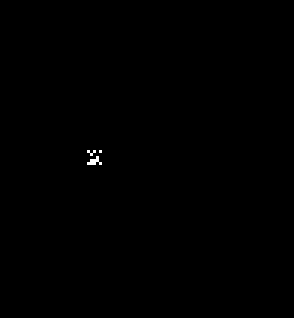

In [121]:
_ = process2(puzzle.input, visualize=True)  # ~3 s.

## Day 25: Text adventure (n,s,e,w)

In [122]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2019/day/25), `puzzle.input` has a single line of 17_577 characters:

109,4806,21101,3124,0,1,21101,0,13,0,1105,1,1424,21102,1,166,1,21101,0,24,0,1105 ... 96,87,89,93,87,97,81,11,86,88,87,87


The stored answers are: `{1: '134349952', 2: ''}`

In [123]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(
        itertools.combinations(s, r) for r in range(len(s) + 1))

In [124]:
def process1(s, num_steps=2000):
  UNSAFE_ITEMS = {'photons', 'infinite loop', 'giant electromagnet',
                  'molten lava', 'escape pod'}
  # 'It is suddenly completely dark! You are eaten by a Grue!'
  # 'The giant electromagnet is stuck to you.  You can't move!!'
  # 'The molten lava is way too hot! You melt!'
  # 'You're launched into space! Bye!'

  machine = Machine(s)
  command = ''
  inventory = set()
  locations = set()

  def encode(command):
    return [ord(ch) for ch in command + '\n']

  def decode(output):
    return ''.join(chr(e) for e in output)

  def issue_command(command):
    return decode(machine.run_until_need_input(
        encode(command) if command else []))

  for step in range(num_steps):
    message = issue_command(command)
    pattern = r'(?s)\n*== (.*) ==\n(.*)\n\n(Doors here.*?)(Items here.*)?'
    location, description, s_doors, s_items = re.fullmatch(
      pattern, message).groups()
    doors = re.findall(r'(?m)^- (\S+)$', s_doors)
    items = re.findall(r'(?m)^- (.*?)$', s_items if s_items else '')
    locations.add(f'{location:<23} {description:<82}'
                  f' [{" ".join(d[0] for d in doors)}]')

    for item in items:
      if item not in UNSAFE_ITEMS:
        message = issue_command(f'take {item}')
        inventory.add(item)

    if location == 'Security Checkpoint':
      if step >= num_steps * 0.5:
        break  # By now we should have taken all the safe items.
      else:
        command = 'east'  # Avoid 'north' to get more time to pick up items.
        continue
    else:
      command = random.choice(doors)
  else:
    assert False

  print('\n'.join(sorted(locations)))
  print(sorted(inventory))  # or: issue_command('inv')
  # ['astrolabe', 'candy cane', 'dark matter', 'hologram', 'klein bottle', 'ornament', 'tambourine', 'whirled peas']
  for items in (set(l) for l in powerset(inventory)):
    for item in inventory:
      command = 'take' if item in items else 'drop'
      message = issue_command(f'{command} {item}')
    message = issue_command('north')
    match = re.search(r'typing (\d+) on the keypad', message)
    if match:
      print(sorted(items))  # ['astrolabe', 'hologram', 'klein bottle', 'tambourine']
      return match.group(1)


puzzle.verify(1, process1)  # ~215 ms.

Arcade                  None of the cabinets seem to have power.                                           [n w]
Corridor                The metal walls and the metal floor are slightly different colors. Or are they?    [w]
Crew Quarters           The beds are all too small for you.                                                [e s w]
Engineering             You see a whiteboard with plans for Springdroid v2.                                [e s w]
Gift Wrapping Center    How else do you wrap presents on the go?                                           [e w]
Hallway                 This area has been optimized for something; you're just not quite sure what.       [w]
Holodeck                Someone seems to have left it on the Giant Grid setting.                           [e s w]
Hot Chocolate Fountain  Somehow, it's still working.                                                       [n]
Hull Breach             You got in through a hole in the floor here. To keep your ship from also

In [125]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


## Timings

In [126]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.001
day_2    part_1: 0.000   part_2: 0.259
day_3    part_1: 0.329   part_2: 0.298
day_4    part_1: 0.004   part_2: 0.006
day_5    part_1: 0.001   part_2: 0.001
day_6    part_1: 0.037   part_2: 0.001
day_7    part_1: 0.080   part_2: 0.120
day_8    part_1: 0.008   part_2: 0.020
day_9    part_1: 0.001   part_2: 0.017
day_10   part_1: 0.146   part_2: 0.152
day_11   part_1: 0.064   part_2: 0.006
day_12   part_1: 0.009   part_2: 0.080
day_13   part_1: 0.004   part_2: 0.069
day_14   part_1: 0.002   part_2: 0.048
day_15   part_1: 0.036   part_2: 0.062
day_16   part_1: 0.107   part_2: 0.289
day_17   part_1: 0.004   part_2: 0.018
day_18   part_1: 0.485   part_2: 0.571
day_19   part_1: 0.376   part_2: 0.526
day_20   part_1: 0.043   part_2: 0.079
day_21   part_1: 0.003   part_2: 0.013
day_22   part_1: 0.001   part_2: 0.001
day_23   part_1: 0.057   part_2: 0.144
day_24   part_1: 0.002   part_2: 0.037
day_25   part_1: 0.326   part_2: 0.000
Total time:  4.943 s


In [127]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [128]:
if 0:  # Look for unwanted pollution of namespace.
  print(textwrap.fill(' '.join(var for var, value in globals().items() if (
      not var.startswith('_') and not repr(value).startswith(
          ('<module', '<class', 'typing.', 'functools.partial('))))))

In [129]:
if 0:  # Save puzzle inputs and answers to a ZIP file for downloading.
  # Create a new zip file, quietly (-q) and ignoring relative paths (-j).
  !zip -q -j - ~/.config/aocd/'{PROFILE.replace("_", " ")}'/*.txt >/content/data.zip

In [130]:
hh.show_notebook_cell_top_times()

Total time: 92.86 s
In[101] '_ = process2(puzzle.input, visualize=True, speed=2)  # Slow 31.768 s
In[ 89] '_ = process1(puzzle.input, visualize=True, speed=3, tail=2) 11.412 s
In[ 91] '_ = process2(puzzle.input, visualize=True, speed=2, tail=2)  9.055 s
In[100] '_ = process1(puzzle.input, visualize=True, speed=1)  # Slow  6.052 s
In[ 67] '_ = ExploreMaze(puzzle.input).farthest_distance_from_destin  3.320 s
In[ 56] '_ = process2(puzzle.input, visualize=True)'                  2.640 s
In[121] '_ = process2(puzzle.input, visualize=True)  # ~3 s.'         2.598 s
In[ 24] "def process1(s, part2=False):  # Using numba to operate on   2.144 s
In[ 47] '_ = process1(puzzle.input, visualize_nth=16)\n_ = process2(  2.053 s
In[ 95] '_ = process2(puzzle.input, visualize=True)  # Slow; ~3.8 s.  2.003 s
In[ 44] '_ = process2(puzzle.input, visualize=True)'                  1.991 s
In[ 87] "def process1(s, part2=False,\n             visualize=False,  1.736 s
In[ 65] '_ = ExploreMaze(puzzle.input).compu

# End